We are an agency helping our customers purchase XoX (a made-up product) from various makers. Price is one of the most important things we care about. We need to estimate the price of a XoX before we recommend it to our customers. However, the estimations vary significantly with our employees' experience. 

We would like you to build a machine learning model to accurately predict the price for a future purchase and provide insights to help us explain the predicted price to our customers. Please note that neither our customers nor us have any knowledge about machine learning. A sample of our sales record is available in ../data/sales.csv.


1. Preprocess, clean, analyze and visualized the provided data. A few sentences or plots describing your approach will suffice. Any thing you would like us to know about the price?
2. Build a machine learning model to help us determine the price for a purchase. Discuss why you choose the approaches, what alternatives you consider, and any concerns you have. How is the performance of your model?
3. Help us understand how the price is predicted (again, a few sentences will suffice).

# XoX Price Prediction Project

## Overview
Our agency helps customers purchase XoX, a specialty product from various makers. One of our key priorities is to recommend products at the right price. However, price estimates can vary based on employee experience, leading to inconsistencies. To address this, we developed a data-driven tool to predict XoX prices accurately and provide clear explanations for our customers, who may not be familiar with technical details.

This project uses historical sales data to:
1. **Analyze and visualize** the data to understand what influences XoX prices.
2. **Build a predictive model** to estimate prices for future purchases.
3. **Explain the predictions** in simple terms to help customers understand how prices are determined.

---

## Problem Definition

### Business Needs
- Accurately predict the price of XoX for future purchases.
- Provide clear, understandable insights to explain predicted prices to customers.

### Approach
We treat this as a **regression problem**, where the goal is to predict the numerical price of XoX based on its attributes (e.g., cost, weight, product type). We measure the model's performance using:
- **Mean Absolute Error (MAE)**: The average difference between predicted and actual prices.
- **Root Mean Squared Error (RMSE)**: A measure that highlights larger prediction errors.
- **R-squared (R²)**: Shows how well the model explains price variations.

---



## <font color='blue'> 1. Data Preprocessing, Cleaning, and Analysis </font>

### Objective
Prepare the sales data for modeling by cleaning it, converting it into a usable format, and exploring patterns to understand what drives XoX prices.

### 1.1 Data Cleaning and Preprocessing
The sales data (from `sales.csv`) contains details about XoX products, such as cost, weight, purchase date, product type, and more. However, the data has some issues:
- **Missing values**: Columns like 'cost' and 'maker' have missing entries. We fill missing 'cost' values with the average cost and handle 'maker' by encoding it appropriately for modeling.
- **Inconsistent formats**: Columns like 'cost', 'weight', 'height', 'width', and 'depth' are stored as text (e.g., "$333k", "3 Ton 90 Kg"). We convert these to numerical values using custom functions.
- **Date feature engineering**: The 'purchase_date' column (e.g., "Dec 19 2008") is converted into numerical features (year, month, day, weekday) to capture any time-related patterns.

Below, we load the necessary libraries, suppress warnings for cleaner output, and load the dataset to inspect its structure.

In [596]:
# This section includes all necessary imports and custom functions for data conversion and transformation. These are foundational and must be run first.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
import warnings
import sys
import os

In [692]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('data/sample_data.csv')
df.head()

cost     price        weight purchase_date product_type product_level  \
0  $333k  $300,492   3 Ton 90 Kg   Dec 19 2008          Q,B      advanced   
1    NaN  $430,570   3 Ton 30 Kg   Sep 10 1997          J,D         basic   
2  $270k  $213,070   3 Ton 40 Kg   Sep 05 2001          J,D         basic   
3    NaN  $229,174   3 Ton 50 Kg   Dec 23 2016            U      advanced   
4   $97k  $122,659  2 Ton 970 Kg   Jan 12 2000          D,R      advanced   

    maker                                    ingredient       height   width  \
0  M14122                             IN732052,IN732053  2.76 meters   97 cm   
1     NaN  IN732054,IN732055,IN732056,IN732057,IN732058  2.67 meters   98 cm   
2     NaN                    IN732054,IN732059,IN732060   3.0 meters   93 cm   
3  M14123                    IN732061,IN732062,IN732063   2.5 meters  102 cm   
4     NaN                    IN732064,IN732065,IN732066  2.47 meters  101 cm   

   depth  
0  26 cm  
1  26 cm  
2  24 cm  
3  27 cm  
4  26 cm

#### - Missing values

In [598]:
# Count missing or NA values in each column
missing_values = df.isna().sum()

# Print the results
print("Number of missing or NA values in each column:")
print(missing_values)

Number of missing or NA values in each column:
cost             981
price             11
weight             4
purchase_date      1
product_type       1
product_level      1
maker            824
ingredient       256
height             0
width              4
depth              4
dtype: int64


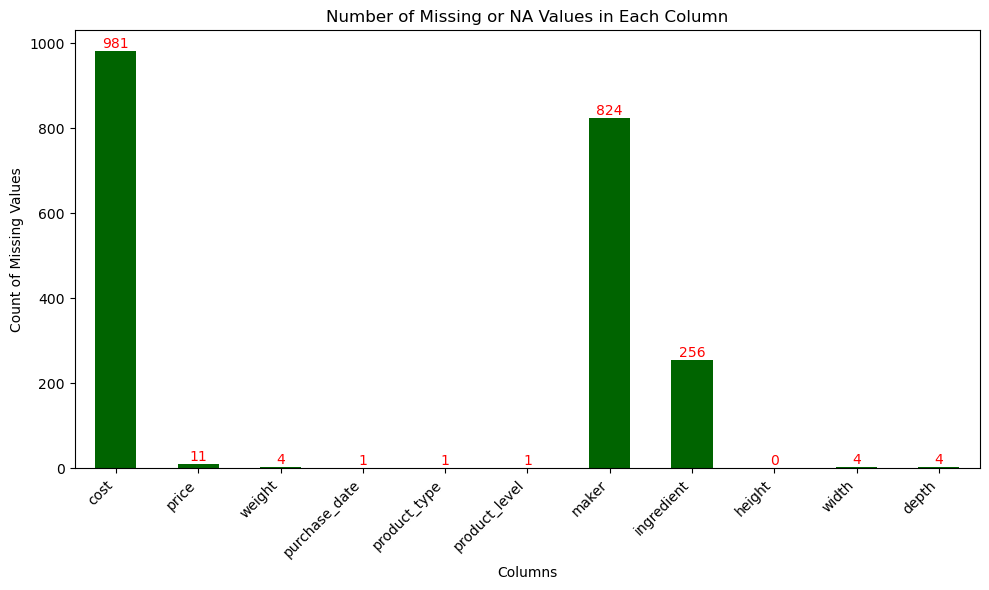

In [599]:
# Visualization by creating bar plot
plt.figure(figsize=(10, 6))
bars = missing_values.plot(kind='bar', color='darkgreen')
plt.title('Number of Missing or NA Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Count of Missing Values')
plt.xticks(rotation=45, ha='right')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# Add numbers on top of each bar
for i, value in enumerate(missing_values):
    plt.text(i, value + 0.1, str(value), ha='center', va='bottom', color="red")
plt.tight_layout()
plt.show()

# Save the plot
plt.savefig('missing_values_plot.png')
plt.close()

<font color="green">##### **Note**:  
**Added Labels**: The line p`lt.text(i, value + 0.1, str(value), ha='center', va='bottom')` adds the count of missing values above each bar.
- `i`: Index of the bar (x-coordinate).
- `value + 0.1`: Places the text slightly above the bar for visibility.
- `str(value)`: Converts the count to a string.
- `ha='center'`: Centers the text horizontally.
- `va='bottom'`: Aligns the text to the bottom of the specified y-coordinate.

#### - Define transformers

In [600]:
# Custom conversion functions
def cost2num(x):
    if pd.isna(x): return np.nan
    if not isinstance(x, str): return x
    try:
        x = x.replace('$', '').replace(',', '').lower()
        if 'k' in x: x = x.replace('k', ''); return float(x) * 1000
        return float(x)
    except (ValueError, TypeError): return np.nan

def price2num(x):
    if pd.isna(x): return np.nan
    if not isinstance(x, str): return x
    try: return float(x.replace('$', '').replace(',', ''))
    except (ValueError, TypeError): return np.nan

def weight2num(x):
    if pd.isna(x): return np.nan
    if not isinstance(x, str): return x
    try:
        x = x.lower().replace('  ', ' ')
        tons = 0.0; kg = 0.0
        if 'ton' in x:
            ton_part = x.split('ton')[0].strip()
            tons = float(ton_part.split()[-1]) if ton_part else 0.0
        if 'kg' in x:
            kg_part = x.split('kg')[0].strip()
            kg = float(kg_part.split()[-1]) if kg_part else 0.0
        return tons * 1000 + kg
    except (ValueError, IndexError): return np.nan

def height2num(x):
    if pd.isna(x): return np.nan
    if not isinstance(x, str): return x
    try: return float(x.replace('meters', '').strip())
    except (ValueError, TypeError): return np.nan

def width2num(x):
    if pd.isna(x): return np.nan
    if not isinstance(x, str): return x
    try: return float(x.replace('cm', '').strip()) / 100
    except (ValueError, TypeError): return np.nan

def depth2num(x):
    if pd.isna(x): return np.nan
    if not isinstance(x, str): return x
    try: return float(x.replace('cm', '').strip()) / 100
    except (ValueError, TypeError): return np.nan

In [601]:
"""
    A transformer to convert specified numerical features to numerical values and impute missing values
    with training set means.
    
    The NumericalTransformer class handles numerical columns like cost, weight, height, width, and depth. 
    During the fit method, it calculates the mean of each numerical column (after applying conversion functions like cost2num). 
    In the transform method, any missing values (NaN) in these columns are imputed with the mean value stored in self.means[col]. 
    For example, missing values in the cost column are replaced with the mean cost computed from the training data.

    Parameters:
    -----------
    features : list
        List of column names to transform.

    Attributes:
    -----------
    means : dict
        Dictionary of mean values for each feature, computed during fit.
"""
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

class NumericalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
        self.means = {}
    
    def fit(self, X, y=None):
        X_numeric = X[self.features].copy()
        converters = {
            'cost': cost2num,
            'weight': weight2num,
            'height': height2num,
            'width': width2num,
            'depth': depth2num
        }
        for col in self.features:
            if col in converters:
                X_numeric[col] = X_numeric[col].apply(converters[col])
            self.means[col] = X_numeric[col].mean()
        return self
    
    def transform(self, X):
        X_numeric = X[self.features].copy()
        converters = {
            'cost': cost2num,
            'weight': weight2num,
            'height': height2num,
            'width': width2num,
            'depth': depth2num
        }
        for col in self.features:
            if col in converters:
                X_numeric[col] = X_numeric[col].apply(converters[col])
            X_numeric[col] = X_numeric[col].fillna(self.means[col])
        return X_numeric

In [602]:
# Custom tokenizer for CountVectorizer
def comma_tokenizer(text):
    return [token.strip() for token in text.split(',') if token.strip()]

# Custom Ordinal Transformer for product_level
class OrdinalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ordinal_mapping = {
            'unrated': 0,
            'basic': 1,
            'intermediate': 2,
            'advanced': 3,
            'super advanced': 4
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X = X.iloc[:, 0]
        result = [self.ordinal_mapping.get(item, -1) for item in X]
        return pd.DataFrame(result, columns=['product_level_ordinal'], index=X.index)

    def fit_transform(self, X, y=None):
        return self.transform(X, y)

# Custom Dummy Transformer for product_type
class Dummy_Transformer(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
        self.keys = None
        
    def fit(self, X, y=None):
        X_col = X[[self.column]].copy()
        X_col[self.column] = X_col[self.column].fillna('Unknown')
        self.keys = set(X_col[self.column])
        return self
    
    def transform(self, X):
        X_col = X[[self.column]].copy()
        X_col[self.column] = X_col[self.column].fillna('Unknown')
        res = {f"{self.column}_{key}": [0]*len(X) for key in self.keys}
        for i, item in enumerate(X_col[self.column]):
            if item in self.keys:
                res[f"{self.column}_{item}"][i] = 1
        return pd.DataFrame(res, index=X.index)
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

#### - Numerical data processing

In [603]:
# Preprocessing
# handle missing values in price
df.dropna(subset=['price'], inplace=True) 

#### - Cat. data processing

In [604]:
# handle missing values,treat missing makers as a separate category, ensuring no data is lost and the column can be used in one-hot encoding later
df['maker'] = df['maker'].fillna('Unknown') 


# Impute missing values in 'ingredient' before preprocessing
df['ingredient'] = df['ingredient'].fillna('unknown_ingredient')

#### - Time data processing

In [605]:
# These features are added as new columns to the DataFrame, enabling the model to capture temporal patterns, 
# such as price trends over years or seasonal effects.
df['purchase_date'] = pd.to_datetime(df['purchase_date'])
df['year'] = df['purchase_date'].dt.year
df['month'] = df['purchase_date'].dt.month
df['weekday'] = df['purchase_date'].dt.weekday
df['day'] = df['purchase_date'].dt.day

In [606]:
df.head()

cost     price        weight purchase_date product_type product_level  \
0  $333k  $300,492   3 Ton 90 Kg    2008-12-19          Q,B      advanced   
1    NaN  $430,570   3 Ton 30 Kg    1997-09-10          J,D         basic   
2  $270k  $213,070   3 Ton 40 Kg    2001-09-05          J,D         basic   
3    NaN  $229,174   3 Ton 50 Kg    2016-12-23            U      advanced   
4   $97k  $122,659  2 Ton 970 Kg    2000-01-12          D,R      advanced   

     maker                                    ingredient       height   width  \
0   M14122                             IN732052,IN732053  2.76 meters   97 cm   
1  Unknown  IN732054,IN732055,IN732056,IN732057,IN732058  2.67 meters   98 cm   
2  Unknown                    IN732054,IN732059,IN732060   3.0 meters   93 cm   
3   M14123                    IN732061,IN732062,IN732063   2.5 meters  102 cm   
4  Unknown                    IN732064,IN732065,IN732066  2.47 meters  101 cm   

   depth  year  month  weekday  day  
0  26 cm  2008     12        4   19  
1  26 cm  1997      9        2   10  
2  24 cm  2001      9        2    5  
3  27 cm  2016     12        4   23  
4  26 cm  2000      1        2   12

### 1.2 Data Visualization and Insights:
- **Distribution of Price and numerical features**: Plotting the distribution of the '`price`' and numerial feature columns to understand its range and skewness. This will help in deciding if any transformation (e.g., log transformation) is needed for the target variable.
- **Correlation Analysis**: Creating a correlation matrix to identify which features are strongly correlated with the price. This can guide feature selection.
- **Feature Relationships**: Visualizing relationships between features like 'weight', 'volume' (to be calculated), and 'price' to see if there are any linear or non-linear patterns.
- **Categorical Features**: Using box plots or bar charts to see how '`product_type`', '`product_level`', and '`ingredient`', '`maker`' affect the price.

#### - **Numerical feature analysis**

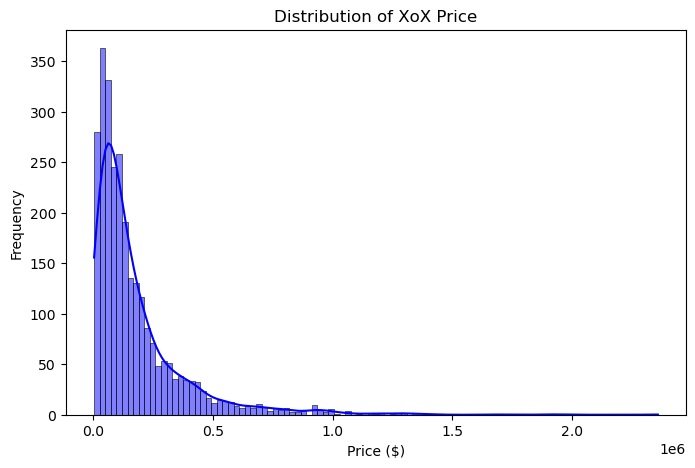

In [607]:
import warnings
warnings.filterwarnings('ignore')
# Pre-model Analysis: Visualize data distributions, correlations, and relationships to gain insights before modeling.
# Convert price to numerical for analysis
train_raw['price'] = train_raw['price'].apply(price2num)

# Visualization 1:  Distribution of Target values: Price
plt.figure(figsize=(8, 5))
sns.histplot(train_raw['price'], kde=True, color='blue')
plt.title('Distribution of XoX Price')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.show();


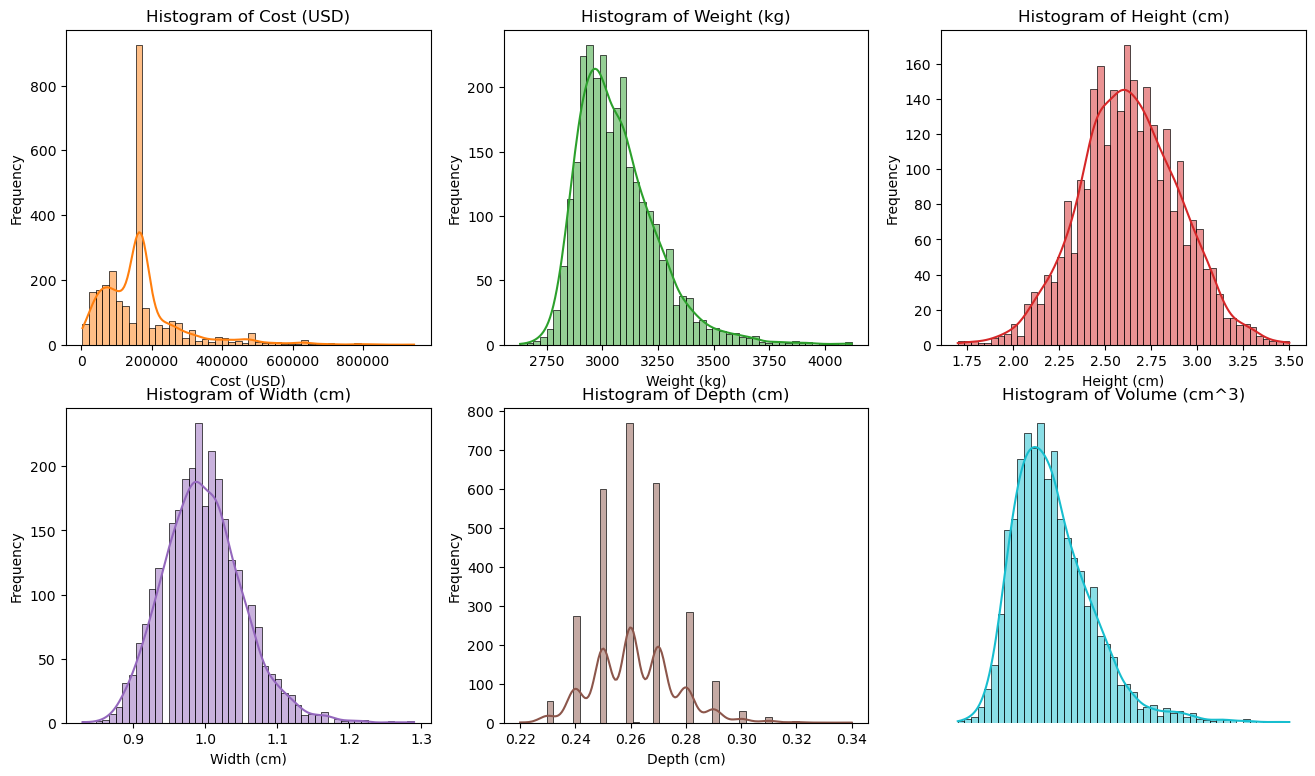

<Figure size 640x480 with 0 Axes>

In [608]:
# Visualization 2: Density Distribution of each numerical feature
# Convert price to numerical for analysis
num_transformer = NumericalTransformer(['cost', 'weight', 'height', 'width', 'depth','volume'])
train_num = num_transformer.fit_transform(train_raw)


# Define colors for each column (suitable for dark/light themes)
colors = {
    # 'price': '#1f77b4',  # Blue
    'cost': '#ff7f0e',   # Orange
    'weight': '#2ca02c', # Green
    'height': '#d62728', # Red
    'width': '#9467bd',  # Purple
    'depth': '#8c564b',  # Brown
    'volume': '#17becf'  # Cyan
}

fig, axes = plt.subplots(2, 3, figsize=(16, 9))
axes = axes.flatten()
columns = [
    # ("price", "Price (USD)"),
    ("cost", "Cost (USD)"),
    ("weight", "Weight (kg)"),
    ("height", "Height (cm)"),
    ("width", "Width (cm)"),
    ("depth", "Depth (cm)"),
    ("volume", "Volume (cm^3)")
]
# Parameter to toggle KDE
show_kde = True  # Set to False to disable KD
# Plot histograms
for i, (col, title) in enumerate(columns):
    hist_data = train_num[col].dropna()
    sns.histplot(data=hist_data, kde=show_kde, color=colors[col], bins=50, edgecolor='black', ax=axes[i])
    axes[i].set_xlabel(title)
    axes[i].set_ylabel("Frequency")
    axes[i].set_title(f"Histogram of {title}")

# Turn off unused subplots
axes[-1].axis('off')
plt.show()

# Adjust layout and save
# plt.tight_layout()

# Adjust spacing: increase hspace for more vertical space between mean and median plots
plt.subplots_adjust(hspace=2.2)  # Increased from default ~0.2
plt.tight_layout()

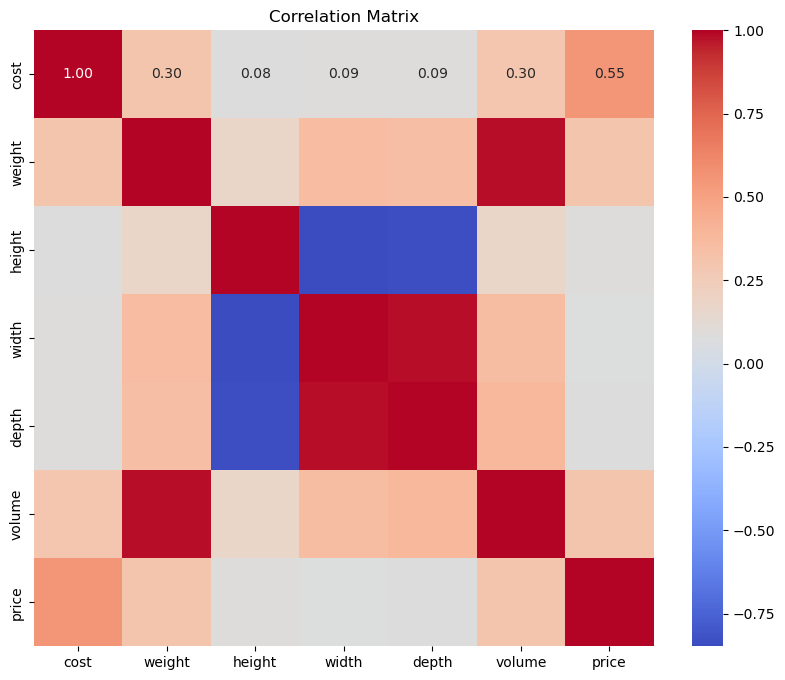

In [609]:
# Visualization 3: Correlation Matrix
# Convert price to numerical for analysis
train_raw['price'] = train_raw['price'].apply(price2num)

num_transformer = NumericalTransformer(['cost', 'weight', 'height', 'width', 'depth','volume'])
train_num = num_transformer.fit_transform(train_raw)
train_num['price'] = train_raw['price']
corr_matrix = train_num.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

#### - Time feature analysis

In [610]:
print(df.head())

    cost     price        weight purchase_date product_type product_level  \
0  $333k  $300,492   3 Ton 90 Kg    2008-12-19          Q,B      advanced   
1    NaN  $430,570   3 Ton 30 Kg    1997-09-10          J,D         basic   
2  $270k  $213,070   3 Ton 40 Kg    2001-09-05          J,D         basic   
3    NaN  $229,174   3 Ton 50 Kg    2016-12-23            U      advanced   
4   $97k  $122,659  2 Ton 970 Kg    2000-01-12          D,R      advanced   

     maker                                    ingredient       height   width  \
0   M14122                             IN732052,IN732053  2.76 meters   97 cm   
1  Unknown  IN732054,IN732055,IN732056,IN732057,IN732058  2.67 meters   98 cm   
2  Unknown                    IN732054,IN732059,IN732060   3.0 meters   93 cm   
3   M14123                    IN732061,IN732062,IN732063   2.5 meters  102 cm   
4  Unknown                    IN732064,IN732065,IN732066  2.47 meters  101 cm   

   depth  year  month  weekday  day  
0  26 cm  20

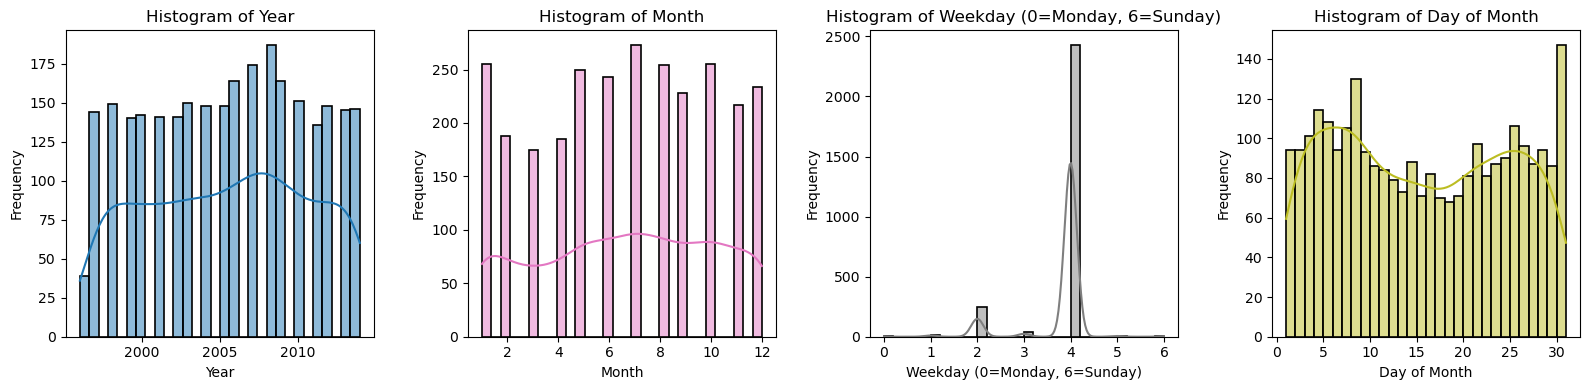

In [611]:
# Visualization: Density Distribution of each temporal feature
# Extract temporal features
def extract_temporal_features(df):
    df = df.copy()
    df['purchase_date'] = pd.to_datetime(df['purchase_date'], errors='coerce')
    df['year'] = df['purchase_date'].dt.year
    df['month'] = df['purchase_date'].dt.month
    df['weekday'] = df['purchase_date'].dt.weekday  # 0=Monday, 6=Sunday
    df['day'] = df['purchase_date'].dt.day
    return df[['year', 'month', 'weekday', 'day']]
# Transform numerical and temporal data
# num_transformer = NumericalTransformer(['cost', 'weight', 'height', 'width', 'depth'])
# train_num = num_transformer.fit_transform(train_raw)
train_temporal = extract_temporal_features(train_raw)
# train_combined = pd.concat([train_num, train_temporal], axis=1)

# Define colors for each column (suitable for dark/light themes)
colors = {
    # 'cost': '#ff7f0e',   # Orange
    # 'weight': '#2ca02c', # Green
    # 'height': '#d62728', # Red
    # 'width': '#9467bd',  # Purple
    # 'depth': '#8c564b',  # Brown
    # 'volume': '#17becf', # Cyan
    'year': '#1f77b4',   # Blue
    'month': '#e377c2',  # Pink
    'weekday': '#7f7f7f',# Gray
    'day': '#bcbd22'     # Olive
}

# Create 2x4 subplot grid
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes = axes.flatten()

# Define columns and their titles
columns = [
    # ("cost", "Cost (USD)"),
    # ("weight", "Weight (kg)"),
    # ("height", "Height (cm)"),
    # ("width", "Width (cm)"),
    # ("depth", "Depth (cm)"),
    # ("volume", "Volume (cm^3)"),
    ("year", "Year"),
    ("month", "Month"),
    ("weekday", "Weekday (0=Monday, 6=Sunday)"),
    ("day", "Day of Month")
]

# Parameter to toggle KDE
show_kde = True  # Set to False to disable KDE

# Plot histograms
for i, (col, title) in enumerate(columns):
    hist_data = train_temporal[col].dropna()
    if len(hist_data) > 0:  # Ensure data exists for plotting
        sns.histplot(data=hist_data, kde=show_kde, color=colors[col], bins=30, edgecolor='black', linewidth=1.2, ax=axes[i])
        axes[i].set_xlabel(title)
        axes[i].set_ylabel("Frequency")
        axes[i].set_title(f"Histogram of {title}")
    else:
        axes[i].set_title(f"Histogram of {title} (No Data)")
        axes[i].set_xlabel(title)
        axes[i].set_ylabel("Frequency")

# Adjust layout and save
plt.tight_layout()
plt.show()
# plt.savefig('histograms_with_temporal_features.png')
# plt.close()

In [612]:
# Convert price to numerical for analysis
df['price'] = df['price'].apply(price2num)

In [613]:
# Extract temporal features
temporal_df = extract_temporal_features(df)

# Merge temporal features with price
plot_df = pd.concat([temporal_df, df['price']], axis=1)

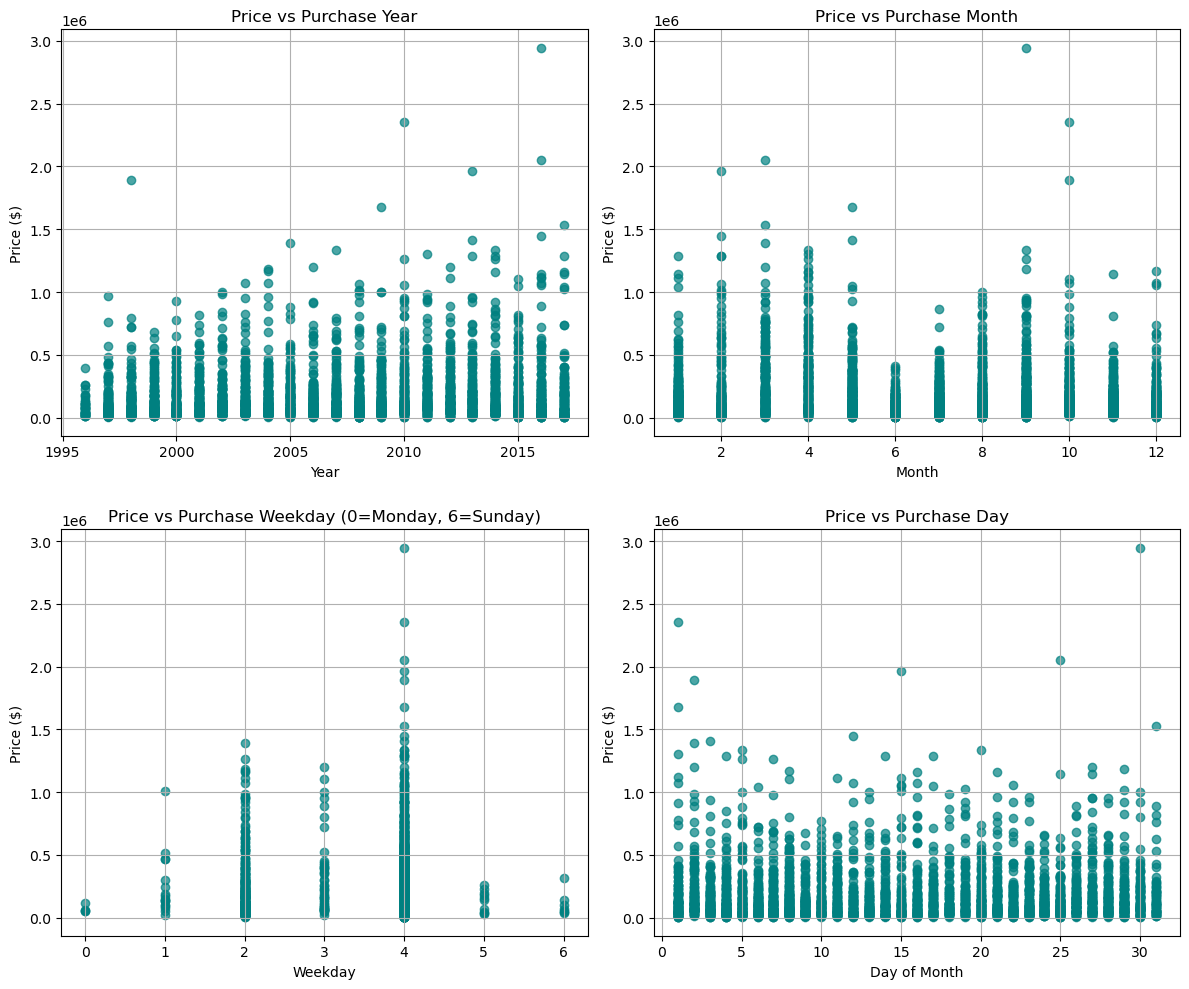

In [614]:
# Create scatter plots for each temporal feature vs price
temporal_features = ['year', 'month', 'weekday', 'day']
titles = ['Price vs Purchase Year', 'Price vs Purchase Month', 
          'Price vs Purchase Weekday (0=Monday, 6=Sunday)', 'Price vs Purchase Day']
x_labels = ['Year', 'Month', 'Weekday', 'Day of Month']

plt.figure(figsize=(12, 10))
for i, feature in enumerate(temporal_features, 1):
    plt.subplot(2, 2, i)
    plt.scatter(plot_df[feature], plot_df['price'], color='teal', alpha=0.7)
    plt.title(titles[i-1])
    plt.xlabel(x_labels[i-1])
    plt.ylabel('Price ($)')
    plt.grid(True)

plt.tight_layout()
plt.show()

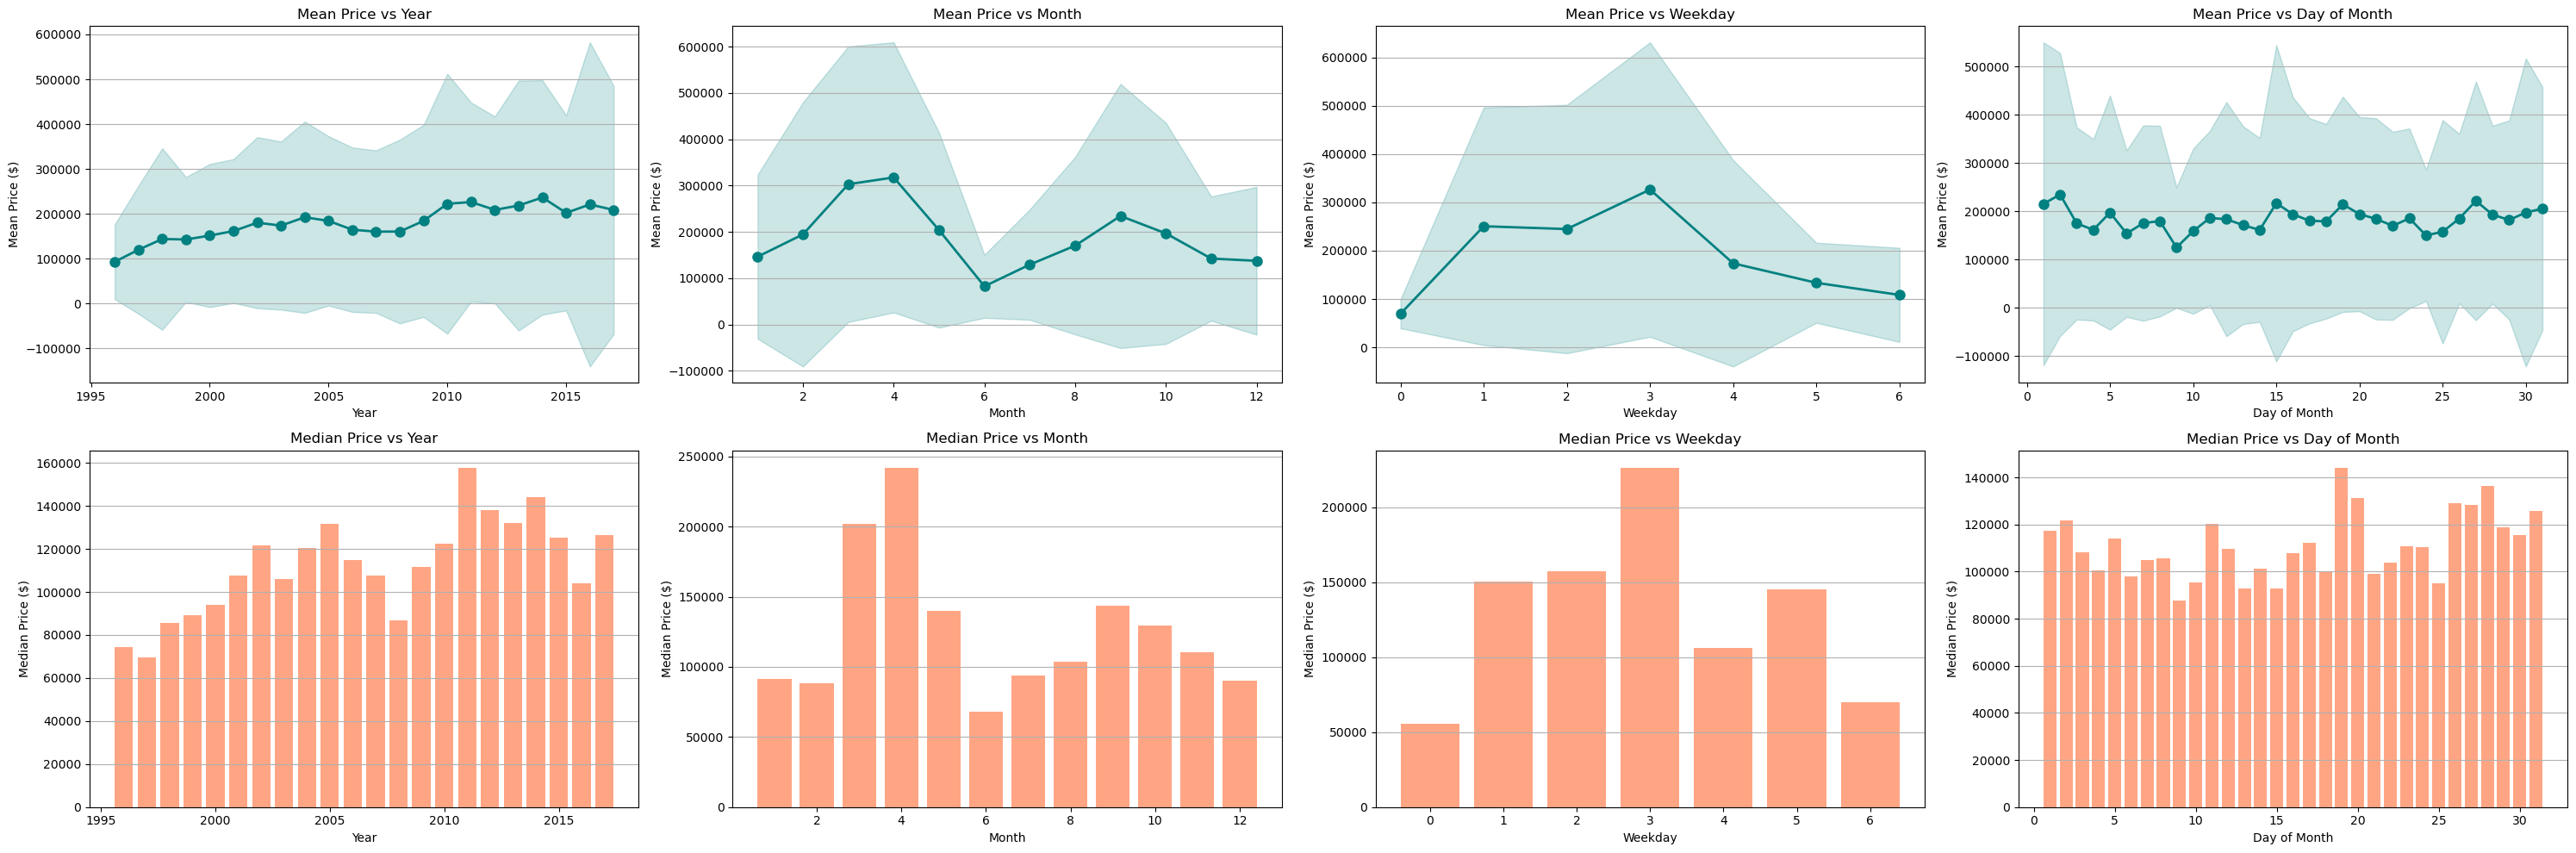

In [615]:
# Create a 2x4 subplot layout (mean and median for each feature)
plt.figure(figsize=(30, 10))

for i, feature in enumerate(temporal_features, 1):
    # Compute mean, standard deviation, and median for each unique value
    grouped = plot_df.groupby(feature)['price'].agg(['mean', 'std', 'median']).reset_index()
    # Sort by feature to ensure lines connect in order
    grouped = grouped.sort_values(feature)
    
    # Mean plot with ribbon band (mean ± std) and line+dot
    plt.subplot(2, 4, i)
    plt.plot(grouped[feature], grouped['mean'], 'o-', color='teal', markersize=8, linewidth=2)
    plt.fill_between(grouped[feature], 
                     grouped['mean'] - grouped['std'].fillna(0), 
                     grouped['mean'] + grouped['std'].fillna(0), 
                     color='teal', alpha=0.2)
    plt.title(f'Mean Price vs {x_labels[i-1]}')
    plt.xlabel(x_labels[i-1])
    plt.ylabel('Mean Price ($)')
    plt.grid(True, axis='y')

    # Median plot (no error bars)
    plt.subplot(2, 4, i + 4)
    plt.bar(grouped[feature], grouped['median'], color='coral', alpha=0.7)
    plt.title(f'Median Price vs {x_labels[i-1]}')
    plt.xlabel(x_labels[i-1])
    plt.ylabel('Median Price ($)')
    plt.grid(True, axis='y')
    
# Adjust spacing: increase hspace for more vertical space between mean and median plots
plt.subplots_adjust(hspace=0.1)  # Increased from default ~0.2
plt.tight_layout()


#### - **Categorical Features analysis**
`product_type`, `product_level`, `maker`, `ingredients`


Unique values for 'product_type': ['Q,B' 'J,D' 'U' 'D,R' 'H' 'S' 'B,A' 'K,D' 'N' 'U,A' 'D' 'H,A' 'G' 'D,A'
 'T,H' 'D,H' 'F' 'A' 'Q,A' 'W' 'F,D' 'R' 'P,H' 'C' 'Q,H' 'U,H' 'J' 'N,D'
 'F,H' 'Q,D' 'V,H' 'W,D' 'S,N' 'N,U' 'F,U' 'P,P' 'S,A' 'U,R' 'J,B' 'I,M'
 'B,D' 'H,M' 'S,U' 'K,H' 'S,B' 'T,D' 'F,A' 'K' 'V' 'N,A' 'B' 'R,V' 'E'
 'U,D' 'L,A' 'L' 'K,A' 'S,D' 'Q,N' 'T,A' 'O' 'B,R' 'N,L' 'K,S']
Number of unique values for 'product_type': 64


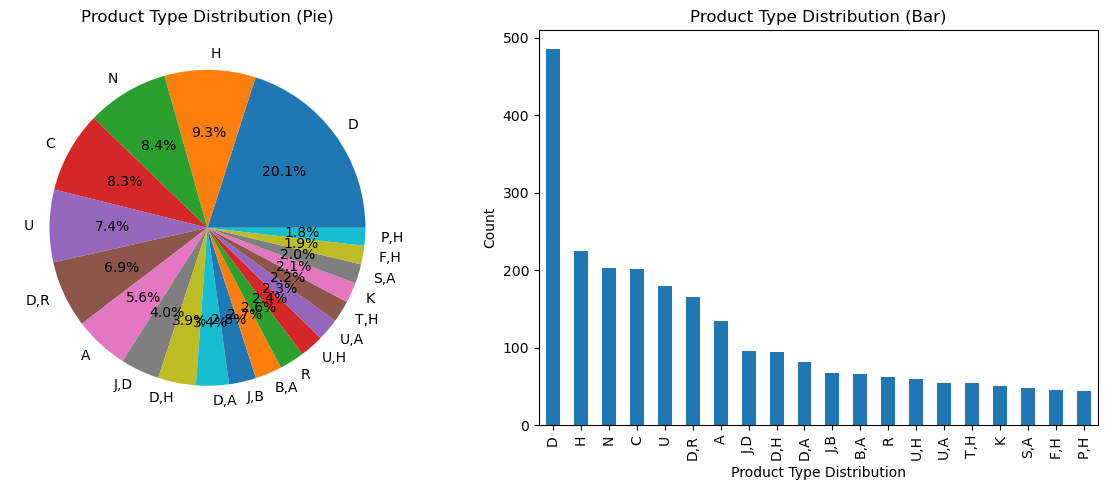


Unique values for 'product_level': ['advanced' 'basic' 'super advanced' 'intermediate' 'unrated']
Number of unique values for 'product_level': 5


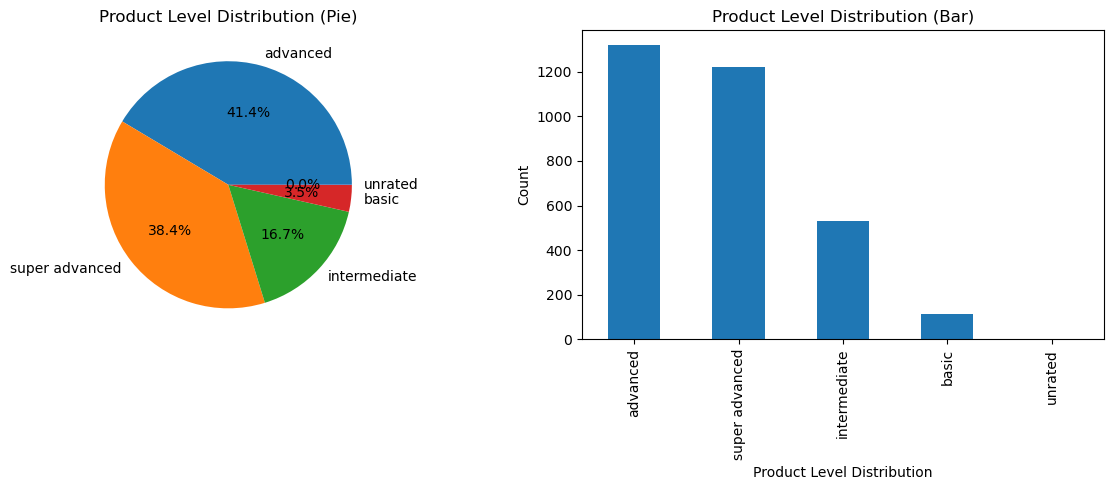


Unique values for 'maker': ['M14122' 'Unknown' 'M14123' 'M14124' 'M14125' 'M14126' 'M14127' 'M14128'
 'M14129' 'M14130' 'M14131' 'M14132' 'M14133' 'M14134,M14135' 'M14136'
 'M14137' 'M14138,M14139' 'M14140' 'M14141' 'M14142' 'M14143' 'M14144'
 'M14145' 'M14146' 'M14147' 'M14148' 'M14149' 'M14150' 'M14151' 'M14152'
 'M14153' 'M14154' 'M14155' 'M14156' 'M14157' 'M14158' 'M14159' 'M14160'
 'M14161' 'M14162' 'M14163' 'M14164' 'M14165' 'M14166' 'M14167' 'M14168'
 'M14169' 'M14170' 'M14171' 'M14172' 'M14173' 'M14174' 'M14175' 'M14176'
 'M14177' 'M14178' 'M14179' 'M14180' 'M14181' 'M14182' 'M14183' 'M14184'
 'M14185' 'M14186' 'M14187' 'M14188' 'M14189' 'M14190' 'M14191' 'M14192'
 'M14193,M14194' 'M14195' 'M14196' 'M14197' 'M14198,M14199' 'M14200'
 'M14201' 'M14202' 'M14194' 'M14203' 'M14204' 'M14205' 'M14206' 'M14207'
 'M14208' 'M14209' 'M14210' 'M14211' 'M14212' 'M14213' 'M14214' 'M14215'
 'M14216' 'M14217' 'M14218' 'M14219,M14220' 'M14221' 'M14222' 'M14223'
 'M14224' 'M14225' 'M14226' 'M14

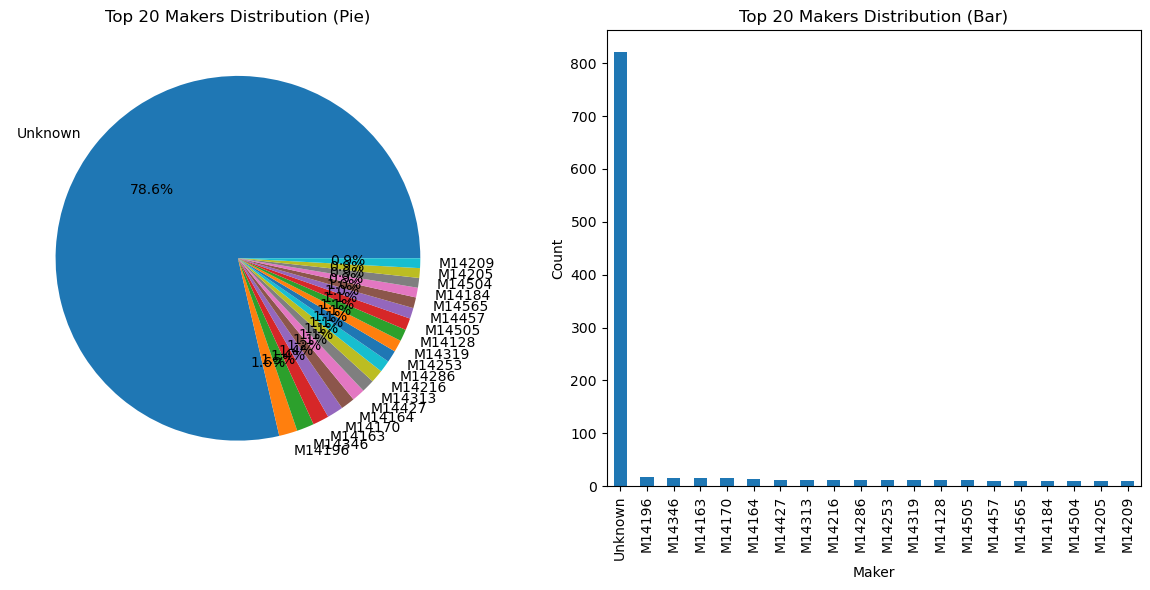


Unique values for 'maker': ['M14122' 'M14123' 'M14124' 'M14125' 'M14126' 'M14127' 'M14128' 'M14129'
 'M14130' 'M14131' 'M14132' 'M14133' 'M14134,M14135' 'M14136' 'M14137'
 'M14138,M14139' 'M14140' 'M14141' 'M14142' 'M14143' 'M14144' 'M14145'
 'M14146' 'M14147' 'M14148' 'M14149' 'M14150' 'M14151' 'M14152' 'M14153'
 'M14154' 'M14155' 'M14156' 'M14157' 'M14158' 'M14159' 'M14160' 'M14161'
 'M14162' 'M14163' 'M14164' 'M14165' 'M14166' 'M14167' 'M14168' 'M14169'
 'M14170' 'M14171' 'M14172' 'M14173' 'M14174' 'M14175' 'M14176' 'M14177'
 'M14178' 'M14179' 'M14180' 'M14181' 'M14182' 'M14183' 'M14184' 'M14185'
 'M14186' 'M14187' 'M14188' 'M14189' 'M14190' 'M14191' 'M14192'
 'M14193,M14194' 'M14195' 'M14196' 'M14197' 'M14198,M14199' 'M14200'
 'M14201' 'M14202' 'M14194' 'M14203' 'M14204' 'M14205' 'M14206' 'M14207'
 'M14208' 'M14209' 'M14210' 'M14211' 'M14212' 'M14213' 'M14214' 'M14215'
 'M14216' 'M14217' 'M14218' 'M14219,M14220' 'M14221' 'M14222' 'M14223'
 'M14224' 'M14225' 'M14226' 'M14227' 'M142

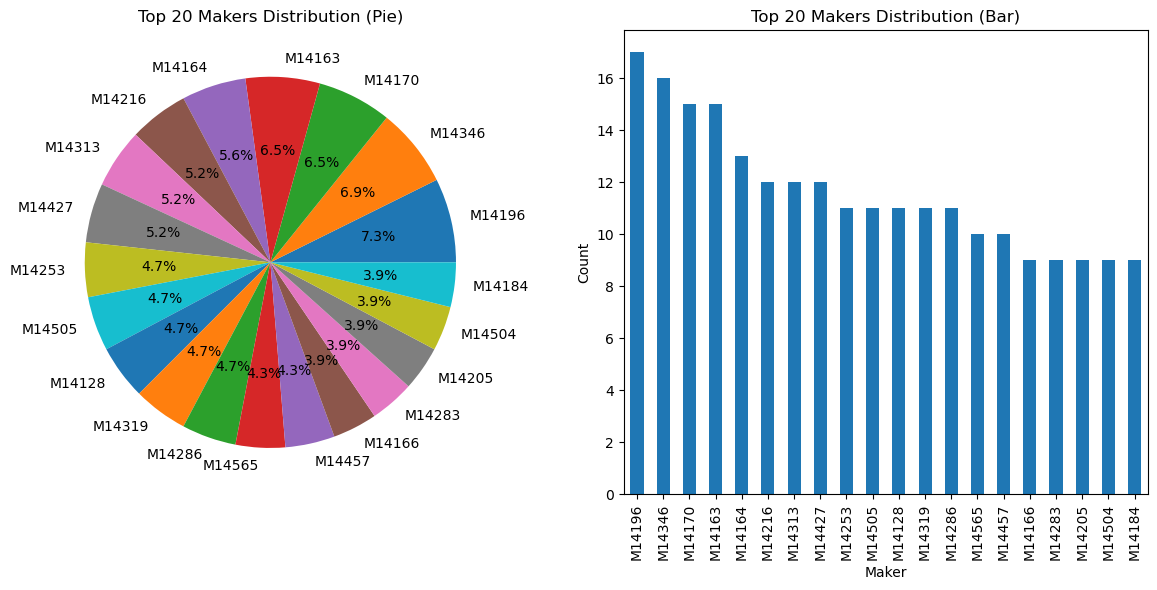


Unique values for 'ingredient': ['IN732052,IN732053' 'IN732054,IN732055,IN732056,IN732057,IN732058'
 'IN732054,IN732059,IN732060' ...
 'IN732490,IN732338,IN732503,IN732435,IN732583'
 'IN732832,IN732166,IN733162,IN733785,IN732069,IN732797'
 'IN733462,IN732654,IN732149,IN733067,IN734088,IN733474,IN732868,IN732266,IN732193']
Number of unique values for 'ingredient': 2825

Value counts for ingredients:
ingredient
unknown_ingredient                                                                  254
IN732638                                                                              8
IN732362                                                                              6
IN732832                                                                              4
IN732502                                                                              4
                                                                                   ... 
IN733467,IN732523,IN733468                                

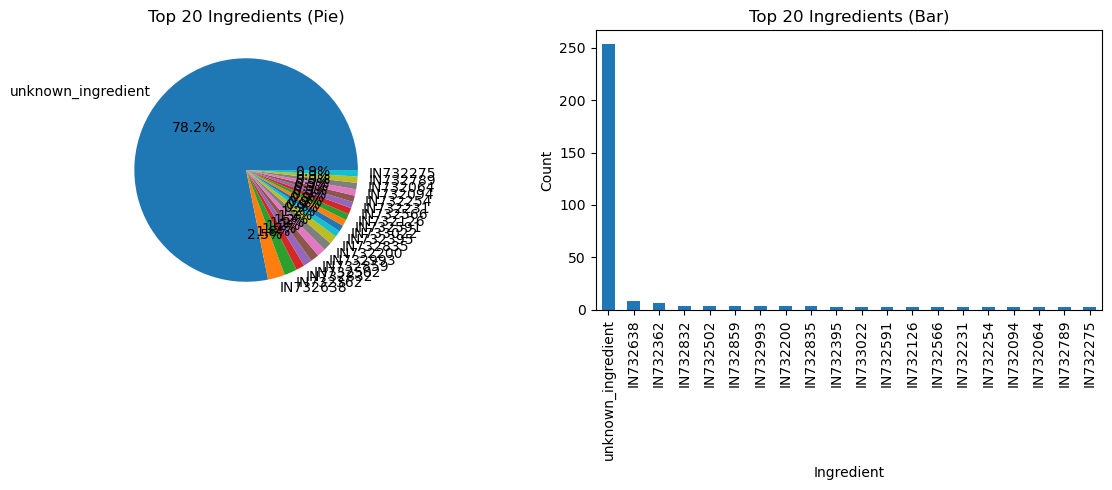

In [616]:
import matplotlib.pyplot as plt

# --- Helper functions ---
def print_unique_info(df, column):
    print(f"\nUnique values for '{column}':", df[column].unique())
    print(f"Number of unique values for '{column}':", df[column].nunique())

def plot_pie_bar(series, title_prefix, top_n=20):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Pie chart
    series.value_counts(dropna=True).head(top_n).plot(
        kind='pie', ax=ax1, autopct='%1.1f%%', title=f"{title_prefix} (Pie)")
    ax1.set_ylabel('')

    # Bar chart
    series.value_counts(dropna=True).head(top_n).plot(
        kind='bar', ax=ax2, title=f"{title_prefix} (Bar)")
    ax2.set_xlabel(title_prefix)
    ax2.set_ylabel("Count")

    plt.tight_layout()
    plt.show()

# ------------------------------
# Analysis for 'product_type'
# ------------------------------
print_unique_info(df, 'product_type')
plot_pie_bar(df['product_type'], "Product Type Distribution")

# ------------------------------
# Analysis for 'product_level'
# ------------------------------
print_unique_info(df, 'product_level')
plot_pie_bar(df['product_level'], "Product Level Distribution")

# ------------------------------
# Analysis for 'maker'
# ------------------------------
print_unique_info(df, 'maker')

# Print top 20 makers
top_makers = df['maker'].value_counts(dropna=True).head(20)
print("\nTop 20 makers by frequency:")
print(top_makers)

# Plot top 20 makers (Pie and Bar)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
top_makers.plot(kind='pie', ax=ax1, autopct='%1.1f%%', title="Top 20 Makers Distribution (Pie)")
ax1.set_ylabel('')
top_makers.plot(kind='bar', ax=ax2, title="Top 20 Makers Distribution (Bar)")
ax2.set_xlabel("Maker")
ax2.set_ylabel("Count")
plt.tight_layout()
plt.show()

# ------------------------------
# Analysis for 'maker' (excluding 'unknown')
# ------------------------------
# Exclude 'unknown' values (case-insensitive) before analysis
filtered_maker_series = df['maker'].dropna()
filtered_maker_series = filtered_maker_series[filtered_maker_series.str.lower() != 'unknown']

# Print uniqueness info
print(f"\nUnique values for 'maker':", filtered_maker_series.unique())
print(f"Number of unique values for 'maker':", filtered_maker_series.nunique())

# Print top 20 makers
top_makers = filtered_maker_series.value_counts().head(20)
print("\nTop 20 makers by frequency (excluding 'unknown'):")
print(top_makers)

# Plot top 20 makers (Pie and Bar)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
top_makers.plot(kind='pie', ax=ax1, autopct='%1.1f%%', title="Top 20 Makers Distribution (Pie)")
ax1.set_ylabel('')
top_makers.plot(kind='bar', ax=ax2, title="Top 20 Makers Distribution (Bar)")
ax2.set_xlabel("Maker")
ax2.set_ylabel("Count")
plt.tight_layout()
plt.show()

# ------------------------------
# Analysis for 'ingredient'
# ------------------------------
print_unique_info(df, 'ingredient')

# Print full ingredient counts
all_ingredients = df['ingredient'].dropna()
ingredient_counts = all_ingredients.value_counts()
print("\nValue counts for ingredients:")
print(ingredient_counts)

# Plot top 20 ingredients
top_ingredients = ingredient_counts.head(20)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
top_ingredients.plot(kind='pie', ax=ax1, autopct='%1.1f%%', title="Top 20 Ingredients (Pie)")
ax1.set_ylabel('')
top_ingredients.plot(kind='bar', ax=ax2, title="Top 20 Ingredients (Bar)")
ax2.set_xlabel("Ingredient")
ax2.set_ylabel("Count")
plt.tight_layout()
plt.show()




Many rows of **`product_type`**, **`maker`**, and **`ingredient`** contain multiple categorical values. For example, "P,R" in **`product_type`** actually indicates this product belongs to two different product types "P" and "R".

Top 10 individual product_type categories:
product_type
D    1100
H     642
A     500
U     393
N     331
R     245
B     217
C     201
J     196
S     177
Name: count, dtype: int64


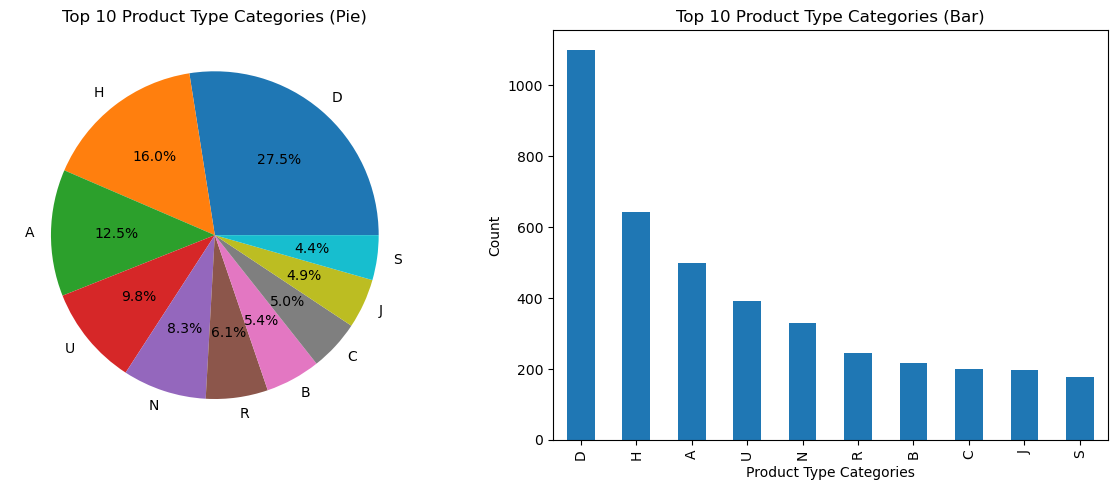


Top 10 individual maker categories:
maker
Unknown    821
M14196      17
M14346      16
M14170      15
M14163      15
M14565      14
M14164      13
M14216      12
M14313      12
M14427      12
Name: count, dtype: int64


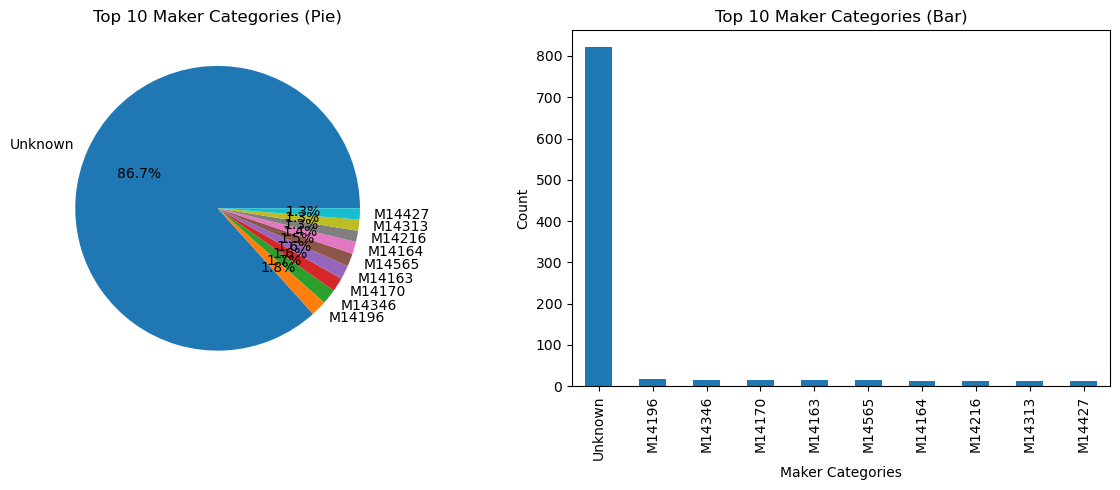


Top 10 individual maker categories (excluding 'unknown'):
maker
M14196    17
M14346    16
M14163    15
M14170    15
M14565    14
M14164    13
M14216    12
M14427    12
M14313    12
M14319    11
Name: count, dtype: int64


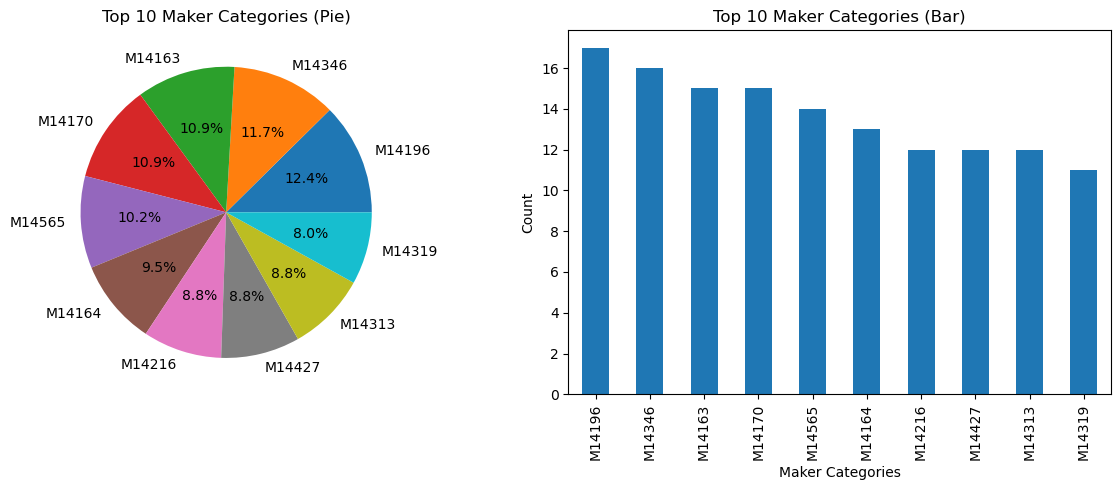


Top 10 individual ingredient categories:
ingredient
unknown_ingredient    254
IN732658               64
IN732094               51
IN732489               44
IN732074               42
IN732583               41
IN732505               40
IN732097               39
IN732231               36
IN732503               36
Name: count, dtype: int64


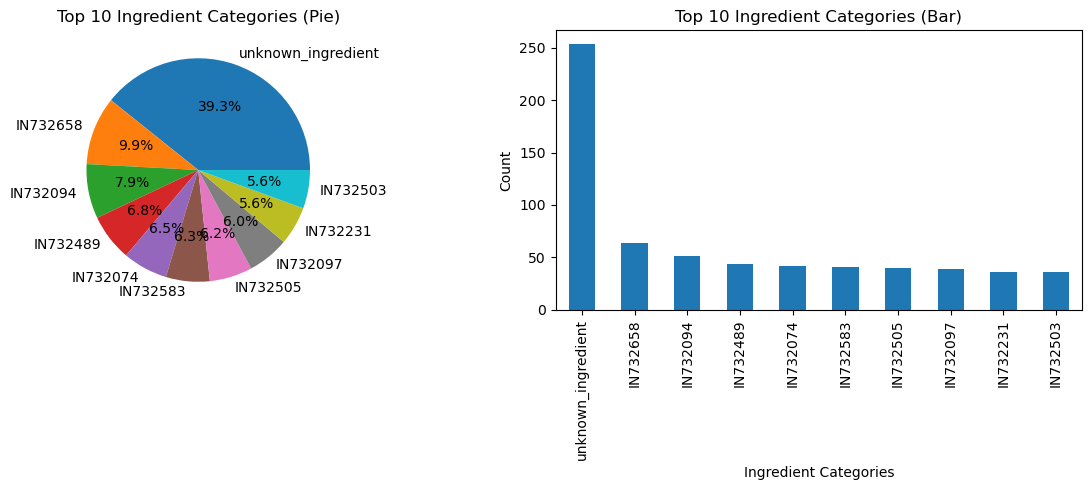

In [617]:
# Handle multi-label categorical values by splitting comma-separated entries and analyzing the individual components.

import matplotlib.pyplot as plt

# --- Helper Functions ---

def explode_and_count(df, column, top_n=10):
    """
    Splits comma-separated strings in a column and counts individual values.
    """
    return df[column].dropna().str.split(',').explode().str.strip().value_counts().head(top_n)

def plot_exploded_counts(counts, title_prefix):
    """
    Plots pie and bar charts for exploded categorical counts.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    counts.plot(kind='pie', ax=ax1, autopct='%1.1f%%', title=f"Top {len(counts)} {title_prefix} (Pie)")
    ax1.set_ylabel('')
    counts.plot(kind='bar', ax=ax2, title=f"Top {len(counts)} {title_prefix} (Bar)")
    ax2.set_xlabel(title_prefix)
    ax2.set_ylabel("Count")
    plt.tight_layout()
    plt.show()

# ------------------------------
# Analysis for 'product_type' (exploded)
# ------------------------------
print("Top 10 individual product_type categories:")
product_type_counts = explode_and_count(df, 'product_type', top_n=10)
print(product_type_counts)
plot_exploded_counts(product_type_counts, "Product Type Categories")

# ------------------------------
# Analysis for 'maker' (exploded)
# ------------------------------
print("\nTop 10 individual maker categories:")
maker_counts = explode_and_count(df, 'maker', top_n=10)
print(maker_counts)
plot_exploded_counts(maker_counts, "Maker Categories")

# ------------------------------
# Analysis for 'maker' (exploded, excluding 'unknown')
# ------------------------------
print("\nTop 10 individual maker categories (excluding 'unknown'):")

# Explode and exclude 'unknown'
makers = df['maker'].dropna().str.split(',').explode().str.strip()
makers = makers[makers.str.lower() != 'unknown']  # Case-insensitive filter
maker_counts = makers.value_counts().head(10)

print(maker_counts)
plot_exploded_counts(maker_counts, "Maker Categories")

# ------------------------------
# Analysis for 'ingredient' (exploded)
# ------------------------------
print("\nTop 10 individual ingredient categories:")
ingredient_counts = explode_and_count(df, 'ingredient', top_n=10)
print(ingredient_counts)
plot_exploded_counts(ingredient_counts, "Ingredient Categories")


### 1.3 Feature Engineering: Create Features Which Might Improve Model Performance

***Numerical Features:***  
Convert 'cost', 'weight', 'height', 'width', and 'depth' to numerical values using the provided functions.
Calculate 'volume' as height * width * depth, as it might be a significant predictor of price.

**Categorical Features:**  
Encode 'product_type', 'product_level', and 'maker' using techniques like one-hot encoding or label encoding, depending on the number of unique categories and their ordinality.

**Temporal Features:**  
Extract 'year', 'month', 'weekday', and 'day' from 'purchase_date' to capture any seasonal or temporal trends in pricing.

**Text Features:**  
If 'ingredient' contains useful information, consider text vectorization techniques.

<font color="red">**Why These Features?**</font>
- 'Volume' combines size-related data into one meaningful number.
- Temporal features might reveal seasonal or yearly price shifts.
- Categorical encoding ensures all product differences are considered.

In [618]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler, FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA

In [619]:
# Feature Engineering
# creat volumn features
df['volume'] = df['height'].apply(height2num) * df['width'].apply(width2num) * df['depth'].apply(depth2num)

In [620]:

# # Prepare features for model input (All features).

# # Define feature lists
# numerical_features = ['cost', 'weight', 'height', 'width', 'depth', 'volume']
# categorical_features = ['product_type', 'product_level', 'maker', 'ingredient']
# temporal_features = ['year', 'month', 'weekday', 'day']
# all_features = numerical_features + categorical_features + temporal_features

In [621]:
# Modified feature lists

numerical_features = ['cost', 'weight', 'volume']
categorical_features = ['product_type', 'product_level']
temporal_features = ['year', 'month','weekday']
all_features = numerical_features + categorical_features + temporal_features

In [ ]:

# Feature preprocessing pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('num_transform', NumericalTransformer(numerical_features)),
            ('scaler', MinMaxScaler())
        ]), numerical_features),
        ('product_type', Dummy_Transformer('product_type'), ['product_type']),
        ('product_level', OrdinalTransformer(), ['product_level']),
        ('temp', 'passthrough', temporal_features)
    ])


In [623]:
# # Preprocessing pipeline (With 'ingredient')
# # Define custom tokenizer to split on commas
# def comma_tokenizer(text):
#     return text.split(',')

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', Pipeline([
#             ('num_transform', NumericalTransformer(numerical_features)),
#             ('scaler', StandardScaler())
#         ]), numerical_features),
#         ('product_type', Dummy_Transformer('product_type'), ['product_type']),
#         ('product_level', OrdinalTransformer(), ['product_level']),
#         ('ingredient', Pipeline([
#             ('vectorizer', CountVectorizer(tokenizer=comma_tokenizer, lowercase=False)),
#             ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
#         ]), 'ingredient'),
#         ('temp', 'passthrough', temporal_features)
#     ])

In [624]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_transform',
                                                  NumericalTransformer(features=['cost',
                                                                                 'weight',
                                                                                 'volume'])),
                                                 ('scaler', MinMaxScaler())]),
                                 ['cost', 'weight', 'volume']),
                                ('product_type',
                                 Dummy_Transformer(column='product_type'),
                                 ['product_type']),
                                ('product_level', OrdinalTransformer(),
                                 ['product_level']),
                                ('temp', 'passthrough',
                                 ['year', 'month', 'weekday'])])

##### ***Technical Note***

##### (1). `preprocessor = ColumnTransformer([...])`

- **What it does**: Creates a `ColumnTransformer` object called `preprocessor`.
- **Purpose**: A `ColumnTransformer` allows you to apply different preprocessing pipelines to different columns of your dataset  
  (e.g., scale numerical columns, one-hot encode categorical ones).

---

##### (2). `'num', Pipeline([...]), numerical_features`

- **`'num'`**: A name/label for this transformation step (useful for referencing or debugging).
- **`Pipeline([...])`**: A pipeline of steps to apply sequentially to the columns in `numerical_features`.
- **`numerical_features`**: A list of column names (or indices) that are numeric and should undergo the pipeline.

- #### Inside the Pipeline:

- **`('scaler', MinMaxScaler())`**
  - **What it does**: Scales each feature to the [0, 1] range.
  - **Why**: Normalizing numeric features can improve performance for many ML algorithms.

- **`('custom', NumericalTransformer(numerical_features))`**
  - **What it does**: Applies a custom transformer called `NumericalTransformer`.
  - **Assumption**: This transformer likely does some additional processing, such as:
    - Filling missing values
    - Creating new features
    - Applying transformations like log-scaling
  - **Important note**: The order may be incorrect here — often you should apply the custom transformer **before** scaling.

---

##### (3). `'cat', OneHotEncoder(...), categorical_features`

- **`'cat'`**: Name of this transformation block (for categorical features).
- **`OneHotEncoder(handle_unknown='ignore', sparse_output=False)`**:
  - Converts each categorical column into one-hot encoded columns  
    (i.e., binary indicator columns for each category).
  - `handle_unknown='ignore'`: If a new category appears during prediction (not seen in training), it ignores it instead of throwing an error.
  - `sparse_output=False`: Returns a dense NumPy array instead of a sparse matrix  
    (easier to work with in many cases).
- **`categorical_features`**: List of your categorical column names to transform.

---

##### (4). `'temp', 'passthrough', temporal_features`

- **`'temp'`**: Name of this block.
- **`'passthrough'`**: Tells the transformer to pass these columns through unchanged — no processing is applied.
- **`temporal_features`**: List of columns containing temporal (time/date) data.


### 1.4 Prepare data for modeling 

In [625]:
# Split data
train_raw = df[df['year'] < 2015].reset_index(drop=True)
test_raw = df[df['year'] >= 2015].reset_index(drop=True)

# Prepare training and test sets
X_train = train_raw[all_features].copy()
y_train = train_raw['price'].apply(price2num)  # Apply price2num here to ensure numeric target
X_test = test_raw[all_features].copy()
y_test = test_raw['price'].apply(price2num)

# Debugging: Verify input shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (2757, 8)
X_test shape: (429, 8)
y_train shape: (2757,)
y_test shape: (429,)


## <font color='blue'> 2. Machine Learning Modeling </font>
I'll build pipelines for each selected model, evaluate them individually using cross-validation, and compare their performance metrics.
### 2.1 Building modeles
 - Selected Models
    - Linear Regression (with and without regularization)
    - Decision Tree Regressor
    - Random Forest Regressor
    - Gradient Boosting
    - XGBoost Regressor

- Pipeline Construction    

    Each pipeline will include:
    - Preprocessing steps (numerical transformation, categorical encoding temporal feature handling)
    - Optional PCA for dimensionality reduction
    - The regressor model

In [626]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA

In [627]:
# Define models and parameter grids
model_objects = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(max_iter=500,random_state=42),
    'Lasso Regression': Lasso(max_iter=500, random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, verbosity=0)
}

### 2.2 Hyperparameter Tuning with Visualization
For each model, I'll define a range of hyperparameters and use GridSearchCV to find the best combination. I'll visualize the results to show how the optimized parameters were selected.

In [628]:
param_grids = {
    'Linear Regression': {
        'poly__degree': [1, 2, 3, 4]
    },
    'Ridge Regression': {
        'poly__degree': [1, 2, 3, 4],
        'regressor__alpha': [0.1, 1.0, 10.0]
    },
    'Lasso Regression': {
        'poly__degree': [1, 2, 3, 4],
        'regressor__alpha': [0.1, 1.0, 10.0]
    },
    'Decision Tree': {
        'regressor__max_depth': [5, 10, 20],
        'regressor__min_samples_split': [2, 10, 20],
        'regressor__min_samples_leaf': [2, 5, 10],
        'regressor__max_features': ['auto', 'sqrt', 'log2']
    },
    'Random Forest': {
        'regressor__n_estimators': [50, 100],
        'regressor__max_depth': [5, 10, 20],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [2, 5, 10],
        'regressor__max_features': ['sqrt', 'log2', 'auto']
    },
    'Gradient Boosting': {
        'regressor__n_estimators': [50, 100],
        'regressor__learning_rate': [0.01, 0.1, 0.3],
        'regressor__max_depth': [5, 10, 20],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [2, 5, 10]
    },
    'XGBoost': {
        'regressor__n_estimators': [50, 100],  # Number of boosting rounds (trees)
        'regressor__learning_rate': [0.01, 0.1, 0.5],  # Step size for each tree’s contribution
        'regressor__max_depth': [5, 10, 20],  # Maximum depth of each tree
        'regressor__min_child_weight': [1, 3, 5],  # Minimum sum of instance weight
        'regressor__subsample': [0.6, 0.8, 1.0],  # Fraction of samples used for training each tree
        'regressor__colsample_bytree': [0.6, 0.8, 1.0]  # Fraction of features used for each tree
    }
}

In [629]:
# Dynamic PCA components
n_features = len(numerical_features) + 1 + len(X_train['product_type'].unique()) + len(temporal_features)
print(n_features)

71


### 2.3 Define piplines

In [630]:
# Create pipelines and grids for each model (with and without PCA)
models = []
for model_name, model in model_objects.items():
    # No PCA pipeline
    if model_name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression']:
        pipeline_no_pca = Pipeline([
            ('preprocessor', preprocessor),
            ('poly', PolynomialFeatures()),
            ('regressor', model)
        ])
    else:
        pipeline_no_pca = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])
    
    # PCA pipeline
    if model_name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression']:
        pipeline_pca = Pipeline([
            ('preprocessor', preprocessor),
            ('pca', PCA()),
            ('poly', PolynomialFeatures()),
            ('regressor', model)
        ])
    else:
        pipeline_pca = Pipeline([
            ('preprocessor', preprocessor),
            ('pca', PCA()),
            ('regressor', model)
        ])
    
    # Parameter grids
    param_grid_no_pca = param_grids[model_name]
    param_grid_pca = param_grids[model_name].copy()
    param_grid_pca['pca__n_components'] = list(range(1, min(n_features, 10)))
    
    # GridSearchCV for No PCA
    grid_no_pca = GridSearchCV(
        pipeline_no_pca,
        param_grid=param_grid_no_pca,
        cv=5,
        scoring='r2',
        return_train_score=True,
        n_jobs=-1
    )
    
    # GridSearchCV for PCA
    grid_pca = GridSearchCV(
        pipeline_pca,
        param_grid=param_grid_pca,
        cv=5,
        scoring='r2',
        return_train_score=True,
        n_jobs=-1
    )
    
    models.append((f"{model_name} No PCA", grid_no_pca, pipeline_no_pca, param_grid_no_pca))
    models.append((f"{model_name} PCA", grid_pca, pipeline_pca, param_grid_pca))


In [631]:
grid_no_pca

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('num_transform',
                                                                                          NumericalTransformer(features=['cost',
                                                                                                                         'weight',
                                                                                                                         'volume'])),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['cost',
                                                                          'weight',
                                                                          'volume']),
                                                                        ('product_type',
                                                                         Dummy_Transformer(column='product_type'),
                                                                         ['product_type']),
                                                                        ('product_level',
                                                                         OrdinalTran...
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'regressor__colsample_bytree': [0.6, 0.8, 1.0],
                         'regressor__learning_rate': [0.01, 0.1, 0.5],
                         'regressor__max_depth': [5, 10, 20],
                         'regressor__min_child_weight': [1, 3, 5],
                         'regressor__n_estimators': [50, 100],
                         'regressor__subsample': [0.6, 0.8, 1.0]},
             return_train_score=True, scoring='r2')

In [632]:
grid_pca

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('num_transform',
                                                                                          NumericalTransformer(features=['cost',
                                                                                                                         'weight',
                                                                                                                         'volume'])),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['cost',
                                                                          'weight',
                                                                          'volume']),
                                                                        ('product_type',
                                                                         Dummy_Transformer(column='product_type'),
                                                                         ['product_type']),
                                                                        ('product_level',
                                                                         OrdinalTran...
                                                     num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'regressor__colsample_bytree': [0.6, 0.8, 1.0],
                         'regressor__learning_rate': [0.01, 0.1, 0.5],
                         'regressor__max_depth': [5, 10, 20],
                         'regressor__min_child_weight': [1, 3, 5],
                         'regressor__n_estimators': [50, 100],
                         'regressor__subsample': [0.6, 0.8, 1.0]},
             return_train_score=True, scoring='r2')

### 2.4 Define metrics

In [633]:
# Initialize results storage
results = []

# Function to evaluate model
def evaluate_model(grid, X_train, y_train, X_test, y_test, model_name):
    best_model = grid.best_estimator_
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    metrics = {
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Test MAE': mean_absolute_error(y_test, y_test_pred),
        'Train MSE': mean_squared_error(y_train, y_train_pred),
        'Test MSE': mean_squared_error(y_test, y_test_pred),
        'Train R²': r2_score(y_train, y_train_pred),
        'Test R²': r2_score(y_test, y_test_pred)
    }
    
    return metrics, y_train_pred, y_test_pred

### 2.5 Fit the models

In [634]:
# Fit and evaluate all models
best_models = {}
for model_name, grid, pipeline, param_grid in models:
    print(f"\nFitting {model_name} with 5-fold cross-validation...")
    try:
        grid.fit(X_train, y_train)
        metrics, y_train_pred, y_test_pred = evaluate_model(grid, X_train, y_train, X_test, y_test, model_name)
        
        # Store results
        result = {
            'Model': model_name,
            'Best Parameters': grid.best_params_,
            'Train MAE': metrics['Train MAE'],
            'Test MAE': metrics['Test MAE'],
            'Train MSE': metrics['Train MSE'],
            'Test MSE': metrics['Test MSE'],
            'Train R²': metrics['Train R²'],
            'Test R²': metrics['Test R²']
        }
        results.append(result)
        
        # Store best model
        base_model_name = model_name.split(' ')[0] + ' ' + model_name.split(' ')[1]
        if base_model_name not in best_models:
            best_models[base_model_name] = {'model': grid.best_estimator_, 'metrics': metrics, 'score': None, 'y_train_pred': y_train_pred, 'y_test_pred': y_test_pred}
        
    except Exception as e:
        print(f"Error fitting {model_name}: {e}")
        preprocessor.fit(X_train)
        for name, transformer, columns in preprocessor.transformers_:
            print(f"\nDebugging transformer: {name}")
            if transformer == 'passthrough':
                X_transformed = X_train[columns].to_numpy()
            else:
                X_transformed = transformer.transform(X_train[columns])
            print(f"Output shape for {name}: {X_transformed.shape}")


Fitting Linear Regression No PCA with 5-fold cross-validation...

Fitting Linear Regression PCA with 5-fold cross-validation...

Fitting Ridge Regression No PCA with 5-fold cross-validation...

Fitting Ridge Regression PCA with 5-fold cross-validation...

Fitting Lasso Regression No PCA with 5-fold cross-validation...

Fitting Lasso Regression PCA with 5-fold cross-validation...

Fitting Decision Tree No PCA with 5-fold cross-validation...

Fitting Decision Tree PCA with 5-fold cross-validation...

Fitting Random Forest No PCA with 5-fold cross-validation...

Fitting Random Forest PCA with 5-fold cross-validation...

Fitting Gradient Boosting No PCA with 5-fold cross-validation...

Fitting Gradient Boosting PCA with 5-fold cross-validation...

Fitting XGBoost No PCA with 5-fold cross-validation...

Fitting XGBoost PCA with 5-fold cross-validation...


In [635]:
# Replace any negtive values wiht zero
for result in results:
    # Check each metric key and replace negative values with zero
    for key in ['Train MAE', 'Test MAE', 'Train MSE', 'Test MSE', 'Train R²', 'Test R²']:
        if result[key] < 0:
            result[key] = 0.0

# Print the updated results
print(results)

[{'Model': 'Linear Regression No PCA', 'Best Parameters': {'poly__degree': 2}, 'Train MAE': 91187.65092680311, 'Test MAE': 148882.20681089914, 'Train MSE': 17507595588.371357, 'Test MSE': 83770622021.40312, 'Train R²': 0.589137739963328, 'Test R²': 0.028308130769181594}, {'Model': 'Linear Regression PCA', 'Best Parameters': {'pca__n_components': 9, 'poly__degree': 2}, 'Train MAE': 108128.43957949834, 'Test MAE': 137160.62554554752, 'Train MSE': 26122410902.204853, 'Test MSE': 52683398392.58933, 'Train R²': 0.3869682032171674, 'Test R²': 0.388902354712758}, {'Model': 'Ridge Regression No PCA', 'Best Parameters': {'poly__degree': 1, 'regressor__alpha': 10.0}, 'Train MAE': 108006.22400266552, 'Test MAE': 140784.78680647124, 'Train MSE': 26042663873.007935, 'Test MSE': 52372577634.946976, 'Train R²': 0.388839679199216, 'Test R²': 0.3925076998289979}, {'Model': 'Ridge Regression PCA', 'Best Parameters': {'pca__n_components': 9, 'poly__degree': 2, 'regressor__alpha': 0.1}, 'Train MAE': 11359

### 2.6 Calculate combined metreics

In [636]:
# Compute composite score with overfitting penalty
def compute_composite_score(metrics, max_mae, max_mse, max_r2_diff):
    norm_test_mae = metrics['Test MAE'] / max_mae
    norm_test_mse = metrics['Test MSE'] / max_mse
    inv_test_mae = 1 - norm_test_mae
    inv_test_mse = 1 - norm_test_mse
    r2_diff = max(0, metrics['Train R²'] - metrics['Test R²'])
    norm_r2_diff = r2_diff / max_r2_diff
    inv_r2_diff = 1 - norm_r2_diff
    test_r2 = metrics['Test R²']
    return 0.05 * inv_test_mae + 0.1 * inv_test_mse + 0.8 * test_r2 + 0.05 * inv_r2_diff

In [637]:
# Calculate composite scores
max_mae = max([r['Test MAE'] for r in results] + [r['Train MAE'] for r in results])
max_mse = max([r['Test MSE'] for r in results] + [r['Train MSE'] for r in results])
max_r2_diff = 1.0

### 2.7 Generate result summary table 

In [638]:
# Create summary table
summary_table = pd.DataFrame([
    {
        'Model': r['Model'],
        'Best Parameters': str(r['Best Parameters']),
        'Train MAE': f"{r['Train MAE']:.2f}",
        'Test MAE': f"{r['Test MAE']:.2f}",
        'Train MSE': f"{r['Train MSE']:.2f}",
        'Test MSE': f"{r['Test MSE']:.2f}",
        'Train R²': f"{r['Train R²']:.4f}",
        'Test R²': f"{r['Test R²']:.4f}",
        'Composite Score': compute_composite_score(r, max_mae, max_mse, max_r2_diff)
    }
    for r in results
]).sort_values(by='Composite Score', ascending=False)

In [639]:
# Export summary table to Excel
summary_table.to_excel('summary_table.xlsx', index=False, engine='openpyxl')

print("\nSummary Table of All Models:")
print(summary_table.to_string(index=False))


Summary Table of All Models:
                   Model                                                                                                                                                                                                        Best Parameters Train MAE  Test MAE      Train MSE       Test MSE Train R² Test R²  Composite Score
          XGBoost No PCA                         {'regressor__colsample_bytree': 0.6, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__min_child_weight': 3, 'regressor__n_estimators': 50, 'regressor__subsample': 1.0}  82500.54 118882.18 14299606780.05 48104562054.58   0.6644  0.4420         0.447529
Gradient Boosting No PCA                                                       {'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__min_samples_leaf': 5, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 50}  81295.26 119848.11 13931041081.00 49162606995.94   0.6731  0.4297         0.43509

#### Visualize summary table

##### - Bar plot

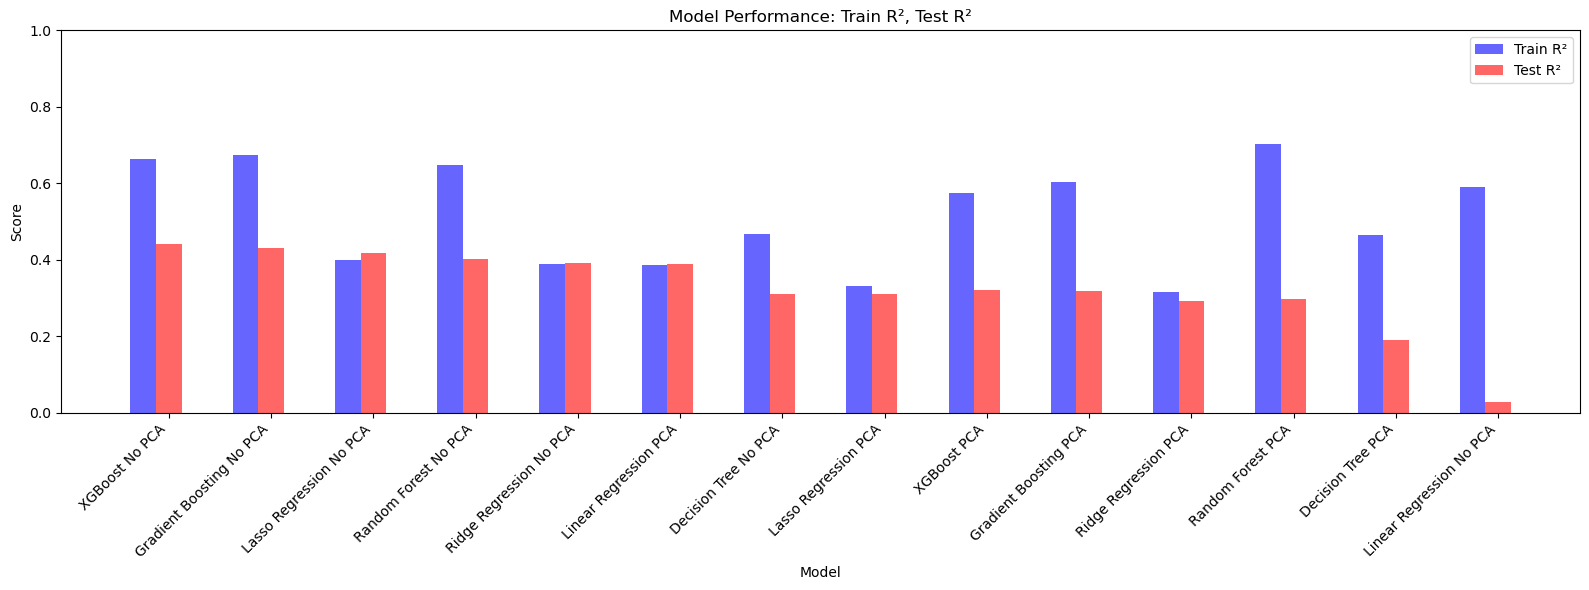

In [640]:
# Visualize summary table
# 1. Bar Plot: Train R², Test R², and Composite Score
plt.figure(figsize=(16, 6))
bar_width = 0.25
index = np.arange(len(summary_table))

plt.bar(index, summary_table['Train R²'].astype(float), bar_width, label='Train R²', color='blue', alpha=0.6)
plt.bar(index + bar_width, summary_table['Test R²'].astype(float), bar_width, label='Test R²', color='red',alpha=0.6)
# plt.bar(index + 2 * bar_width, summary_table['Composite Score'], bar_width, label='Composite Score', color='darkgreen',alpha=0.6)
plt.ylim([0,1])
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance: Train R², Test R²')
plt.xticks(index + bar_width, summary_table['Model'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()

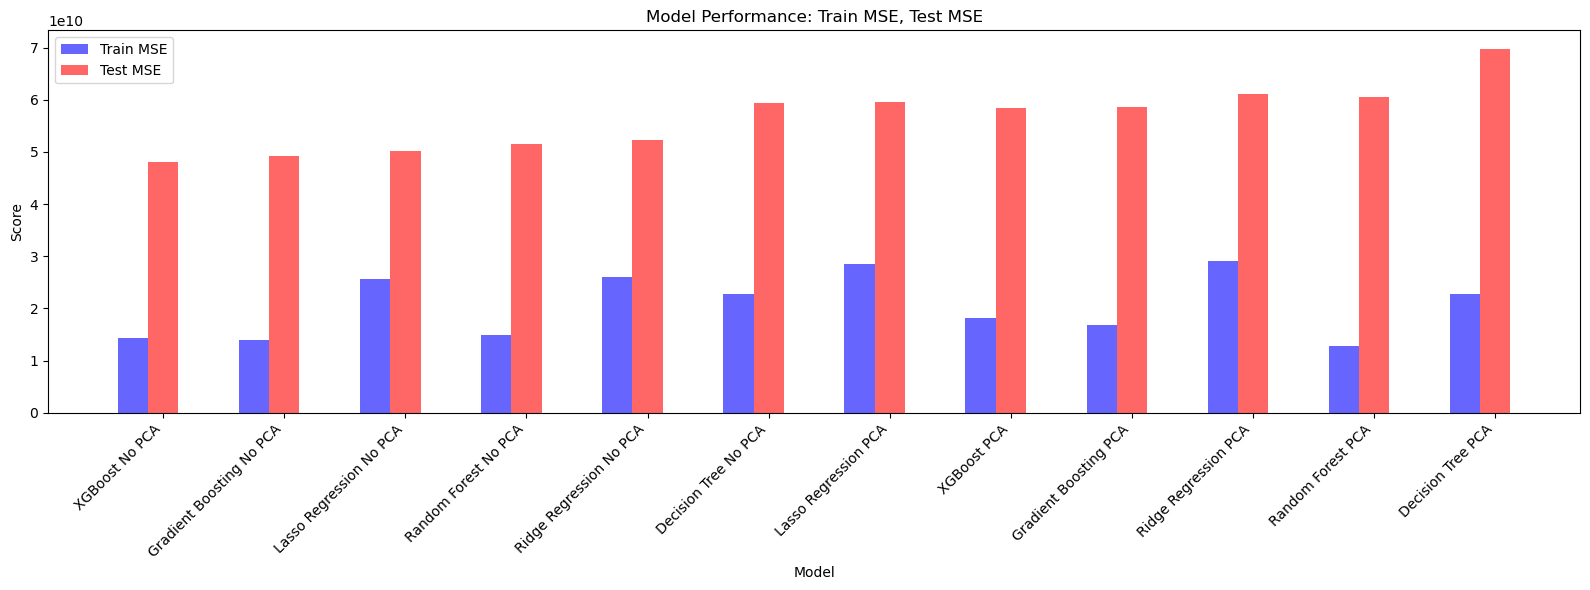

In [641]:
summary_table = summary_table[~summary_table['Model'].str.contains('Linear Regression')].reset_index(drop=True)
# 1. Bar Plot: Train R², Test R², and Composite Score
plt.figure(figsize=(16, 6))
bar_width = 0.25
index = np.arange(len(summary_table))

plt.bar(index, summary_table['Train MSE'].astype(float), bar_width, label='Train MSE', color='blue', alpha=0.6)
plt.bar(index + bar_width, summary_table['Test MSE'].astype(float), bar_width, label='Test MSE', color='red',alpha=0.6)
# plt.bar(index + 2 * bar_width, summary_table['Composite Score'], bar_width, label='Composite Score', color='darkgreen',alpha=0.6)
# plt.ylim([0,1])
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance: Train MSE, Test MSE')
plt.xticks(index + bar_width, summary_table['Model'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()

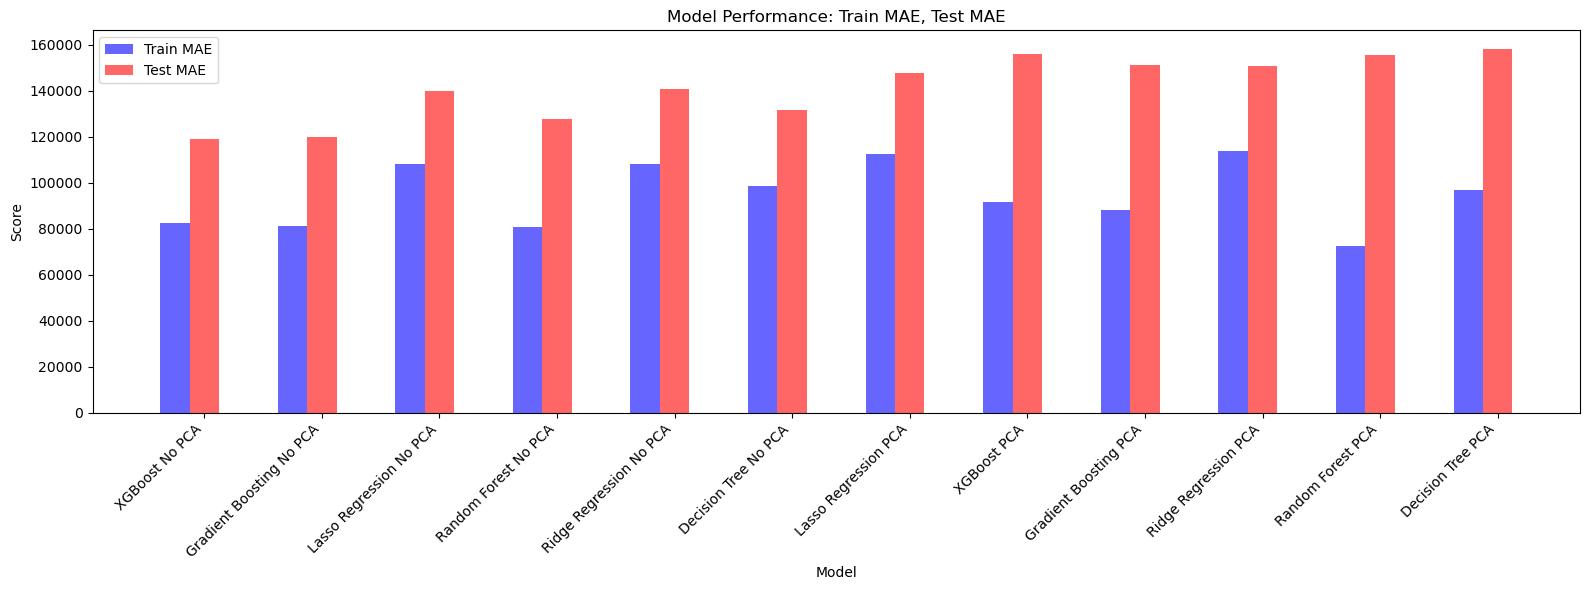

In [674]:
summary_table = summary_table[~summary_table['Model'].str.contains('Linear Regression')].reset_index(drop=True)
# 1. Bar Plot: Train MAE, Test MAE, and Composite Score
plt.figure(figsize=(16, 6))
bar_width = 0.25
index = np.arange(len(summary_table))

plt.bar(index, summary_table['Train MAE'].astype(float), bar_width, label='Train MAE', color='blue', alpha=0.6)
plt.bar(index + bar_width, summary_table['Test MAE'].astype(float), bar_width, label='Test MAE', color='red',alpha=0.6)
# plt.bar(index + 2 * bar_width, summary_table['Composite Score'], bar_width, label='Composite Score', color='darkgreen',alpha=0.6)
# plt.ylim([0,1])
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance: Train MAE, Test MAE')
plt.xticks(index + bar_width, summary_table['Model'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()

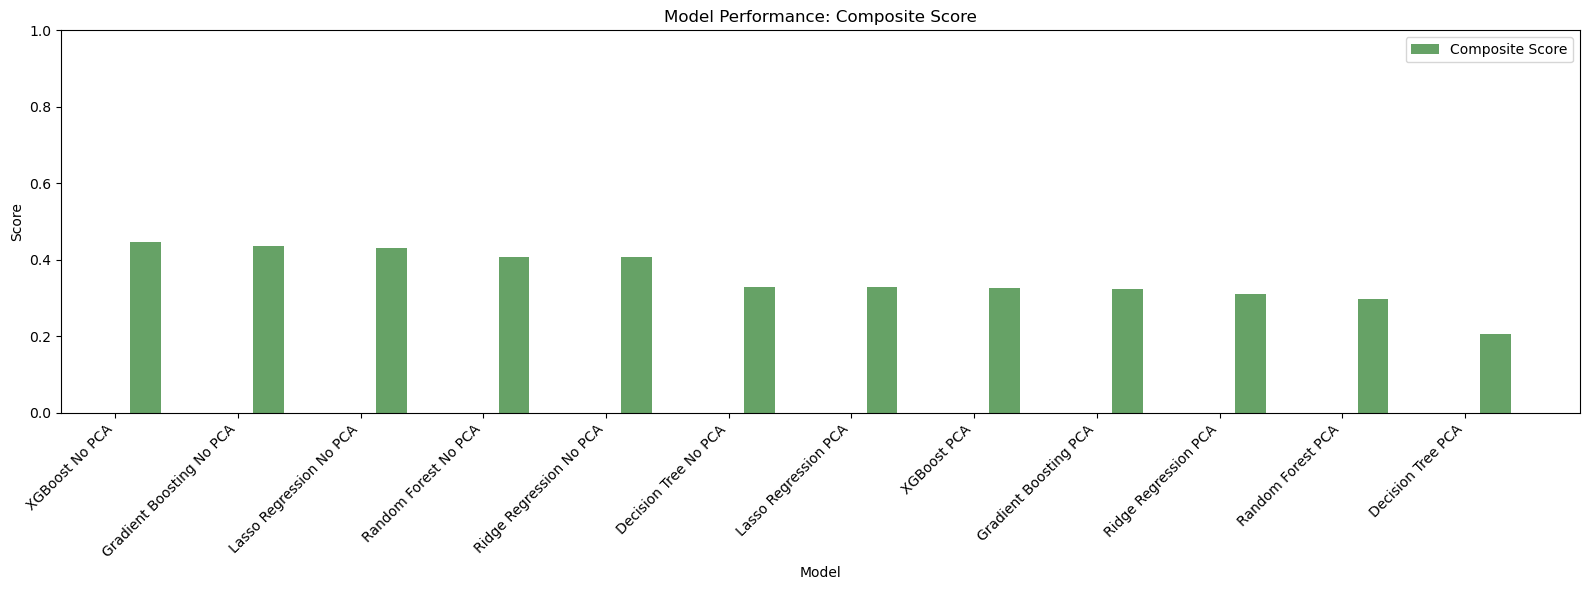

In [642]:
# Bar Plot: Train R², Test R², and Composite Score
plt.figure(figsize=(16, 6))
bar_width = 0.25
index = np.arange(len(summary_table))


plt.bar(index + 2 * bar_width, summary_table['Composite Score'], bar_width, label='Composite Score', color='darkgreen',alpha=0.6)
plt.ylim([0,1])
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance: Composite Score')
plt.xticks(index + bar_width, summary_table['Model'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()

In [643]:
summary_table


Model  \
0             XGBoost No PCA   
1   Gradient Boosting No PCA   
2    Lasso Regression No PCA   
3       Random Forest No PCA   
4    Ridge Regression No PCA   
5       Decision Tree No PCA   
6       Lasso Regression PCA   
7                XGBoost PCA   
8      Gradient Boosting PCA   
9       Ridge Regression PCA   
10         Random Forest PCA   
11         Decision Tree PCA   

                                      Best Parameters  Train MAE   Test MAE  \
0   {'regressor__colsample_bytree': 0.6, 'regresso...   82500.54  118882.18   
1   {'regressor__learning_rate': 0.1, 'regressor__...   81295.26  119848.11   
2       {'poly__degree': 1, 'regressor__alpha': 10.0}  108339.84  139812.18   
3   {'regressor__max_depth': 20, 'regressor__max_f...   80671.26  127745.17   
4       {'poly__degree': 1, 'regressor__alpha': 10.0}  108006.22  140784.79   
5   {'regressor__max_depth': 5, 'regressor__max_fe...   98578.65  131504.50   
6   {'pca__n_components': 9, 'poly__degree': 2, 'r...  112570.62  147787.77   
7   {'pca__n_components': 9, 'regressor__colsample...   91482.46  155881.80   
8   {'pca__n_components': 8, 'regressor__learning_...   88361.85  151279.72   
9   {'pca__n_components': 9, 'poly__degree': 2, 'r...  113595.47  150620.03   
10  {'pca__n_components': 9, 'regressor__max_depth...   72540.57  155452.56   
11  {'pca__n_components': 8, 'regressor__max_depth...   96703.05  158349.64   

         Train MSE        Test MSE Train R² Test R²  Composite Score  
0   14299606780.05  48104562054.58   0.6644  0.4420         0.447529  
1   13931041081.00  49162606995.94   0.6731  0.4297         0.435097  
2   25586717774.87  50206463573.20   0.3995  0.4176         0.430027  
3   14980872971.70  51492740251.76   0.6484  0.4027         0.408079  
4   26042663873.01  52372577634.95   0.3888  0.3925         0.407033  
5   22731852841.43  59374826756.38   0.4665  0.3113         0.328865  
6   28503935259.87  59531822477.65   0.3311  0.3095         0.328761  
7   18153679428.65  58473807545.77   0.5740  0.3217         0.325755  
8   16889285826.41  58699689062.08   0.6036  0.3191         0.323227  
9   29109381182.65  61057696167.24   0.3169  0.2918         0.311711  
10  12717767826.65  60489463360.71   0.7015  0.2984         0.297232  
11  22821703058.28  69809129027.10   0.4644  0.1903         0.205160

In [644]:
# Remove Linear Regression models
summary_table = summary_table[~summary_table['Model'].str.contains('Linear Regression')].reset_index(drop=True)

##### - Heatmap

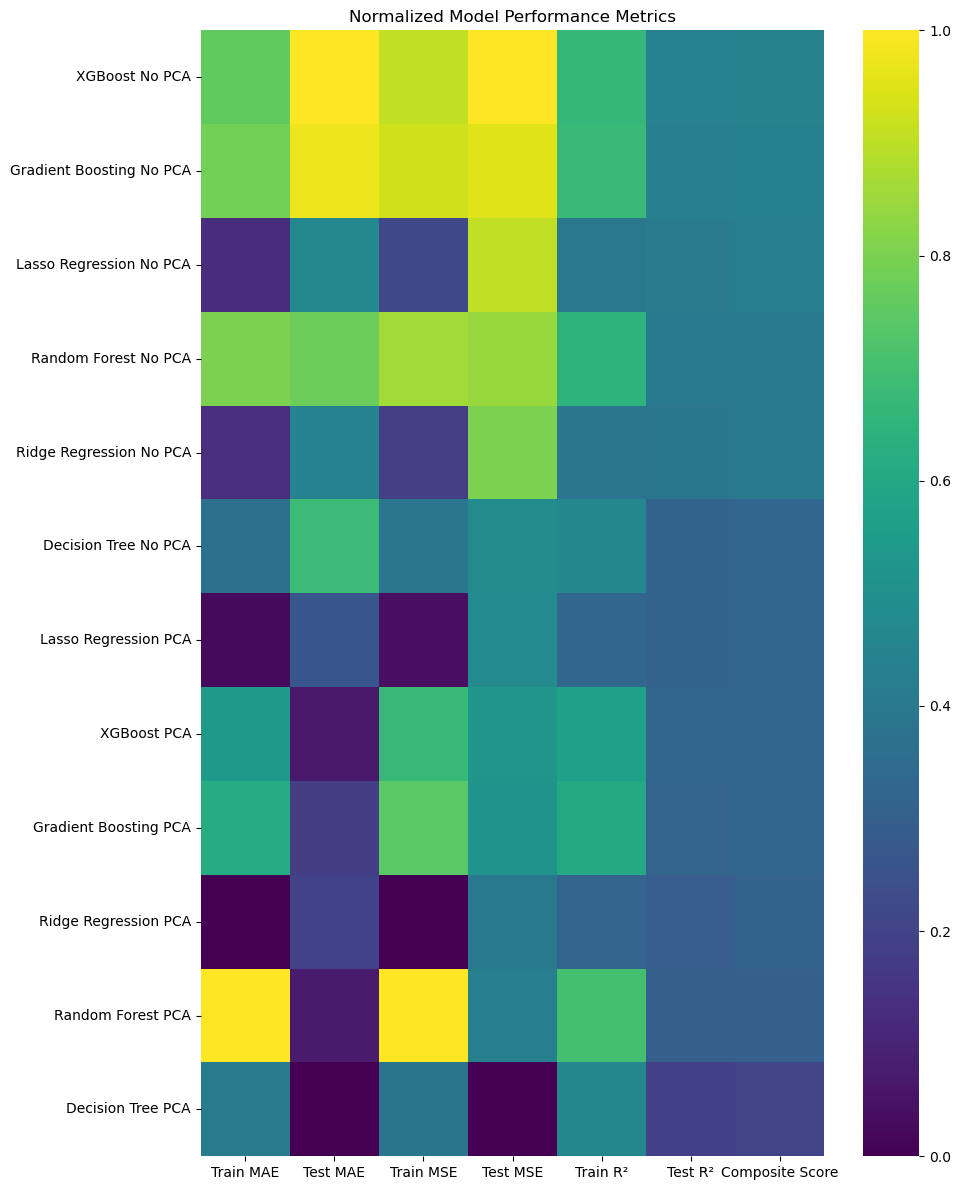

In [645]:
# 2. Heatmap: Normalized Metrics
metrics_columns = ['Train MAE', 'Test MAE', 'Train MSE', 'Test MSE', 'Train R²', 'Test R²', 'Composite Score']
heatmap_data = summary_table[metrics_columns].astype(float)

# Normalize only MAE and MSE metrics, keep R² and Composite Score as raw
heatmap_data_normalized = heatmap_data.copy()
for col in ['Train MAE', 'Test MAE', 'Train MSE', 'Test MSE']:
    heatmap_data_normalized[col] = (heatmap_data[col] - heatmap_data[col].min()) / (heatmap_data[col].max() - heatmap_data[col].min())
    heatmap_data_normalized[col] = 1 - heatmap_data_normalized[col]  # Invert error metrics

# Export normalized metric table to CSV
heatmap_data_normalized['Model'] = summary_table['Model']
heatmap_data_normalized = heatmap_data_normalized[['Model'] + metrics_columns]  # Reorder columns
heatmap_data_normalized.to_csv('normalized_metrics.csv', index=False)

plt.figure(figsize=(10, 12))
sns.heatmap(heatmap_data_normalized[metrics_columns], cmap='viridis', fmt='.2f', xticklabels=metrics_columns, yticklabels=summary_table['Model'])
plt.title('Normalized Model Performance Metrics')
plt.tight_layout()


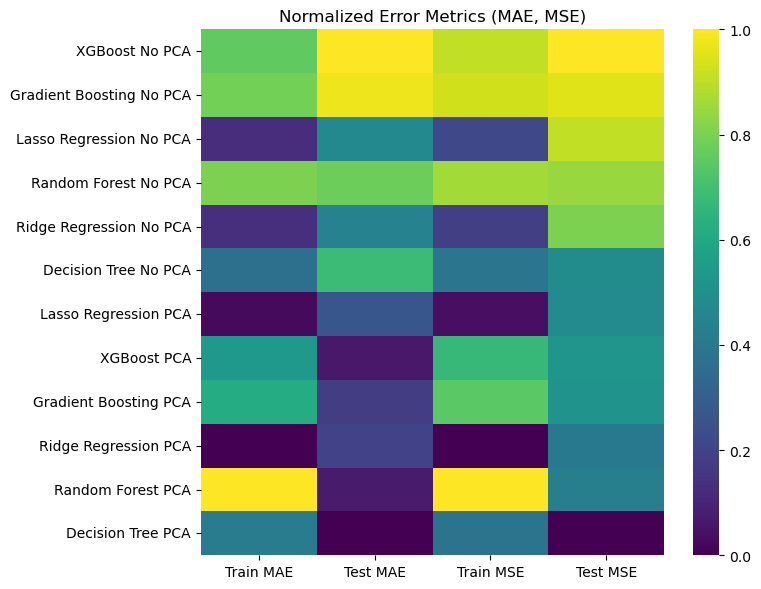

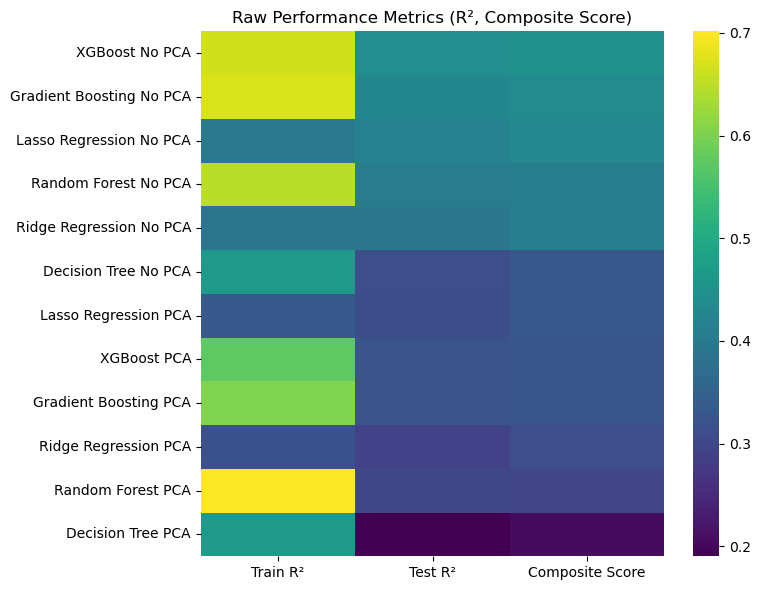

In [646]:
# Define column groups
group1 = ['Train MAE', 'Test MAE', 'Train MSE', 'Test MSE']
group2 = ['Train R²', 'Test R²', 'Composite Score']

# Group 1 Heatmap: Error metrics (normalized & inverted)
plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data_normalized[group1],
    cmap='viridis',
    xticklabels=group1,
    yticklabels=summary_table['Model']
)
plt.title('Normalized Error Metrics (MAE, MSE)')
plt.tight_layout()
plt.show()

# Group 2 Heatmap: Raw metrics (R² and Composite Score)
plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data_normalized[group2],
    cmap='viridis',
    xticklabels=group2,
    yticklabels=summary_table['Model']
)
plt.title('Raw Performance Metrics (R², Composite Score)')
plt.tight_layout()
plt.show()

In [647]:
print(heatmap_data)

    Train MAE   Test MAE     Train MSE      Test MSE  Train R²  Test R²  \
0    82500.54  118882.18  1.429961e+10  4.810456e+10    0.6644   0.4420   
1    81295.26  119848.11  1.393104e+10  4.916261e+10    0.6731   0.4297   
2   108339.84  139812.18  2.558672e+10  5.020646e+10    0.3995   0.4176   
3    80671.26  127745.17  1.498087e+10  5.149274e+10    0.6484   0.4027   
4   108006.22  140784.79  2.604266e+10  5.237258e+10    0.3888   0.3925   
5    98578.65  131504.50  2.273185e+10  5.937483e+10    0.4665   0.3113   
6   112570.62  147787.77  2.850394e+10  5.953182e+10    0.3311   0.3095   
7    91482.46  155881.80  1.815368e+10  5.847381e+10    0.5740   0.3217   
8    88361.85  151279.72  1.688929e+10  5.869969e+10    0.6036   0.3191   
9   113595.47  150620.03  2.910938e+10  6.105770e+10    0.3169   0.2918   
10   72540.57  155452.56  1.271777e+10  6.048946e+10    0.7015   0.2984   
11   96703.05  158349.64  2.282170e+10  6.980913e+10    0.4644   0.1903   

    Composite Score  
0 

In [648]:
print(heatmap_data_normalized)

                       Model  Train MAE  Test MAE  Train MSE  Test MSE  \
0             XGBoost No PCA   0.757399  1.000000   0.903497  1.000000   
1   Gradient Boosting No PCA   0.786757  0.975526   0.925982  0.951252   
2    Lasso Regression No PCA   0.128015  0.469690   0.214906  0.903159   
3       Random Forest No PCA   0.801956  0.775436   0.861935  0.843896   
4    Ridge Regression No PCA   0.136141  0.445046   0.187091  0.803359   
5       Decision Tree No PCA   0.365774  0.680184   0.389073  0.480742   
6       Lasso Regression PCA   0.024963  0.267610   0.036936  0.473509   
7                XGBoost PCA   0.538620  0.062528   0.668372  0.522255   
8      Gradient Boosting PCA   0.614631  0.179133   0.745509  0.511848   
9       Ridge Regression PCA   0.000000  0.195848   0.000000  0.403207   
10         Random Forest PCA   1.000000  0.073404   1.000000  0.429387   
11         Decision Tree PCA   0.411459  0.000000   0.383591  0.000000   

    Train R²  Test R²  Composite Scor

##### - Radar plot (stacked)

In [649]:

# Define metrics for radar plots
include_composite_score = False  # Set to False to exclude Composite Score
base_metrics = ['Train MAE', 'Train MSE', 'Train R²', 'Test MAE', 'Test MSE', 'Test R²']
selected_metrics = base_metrics + ['Composite Score'] if include_composite_score else base_metrics
num_vars = len(selected_metrics)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Close the loop

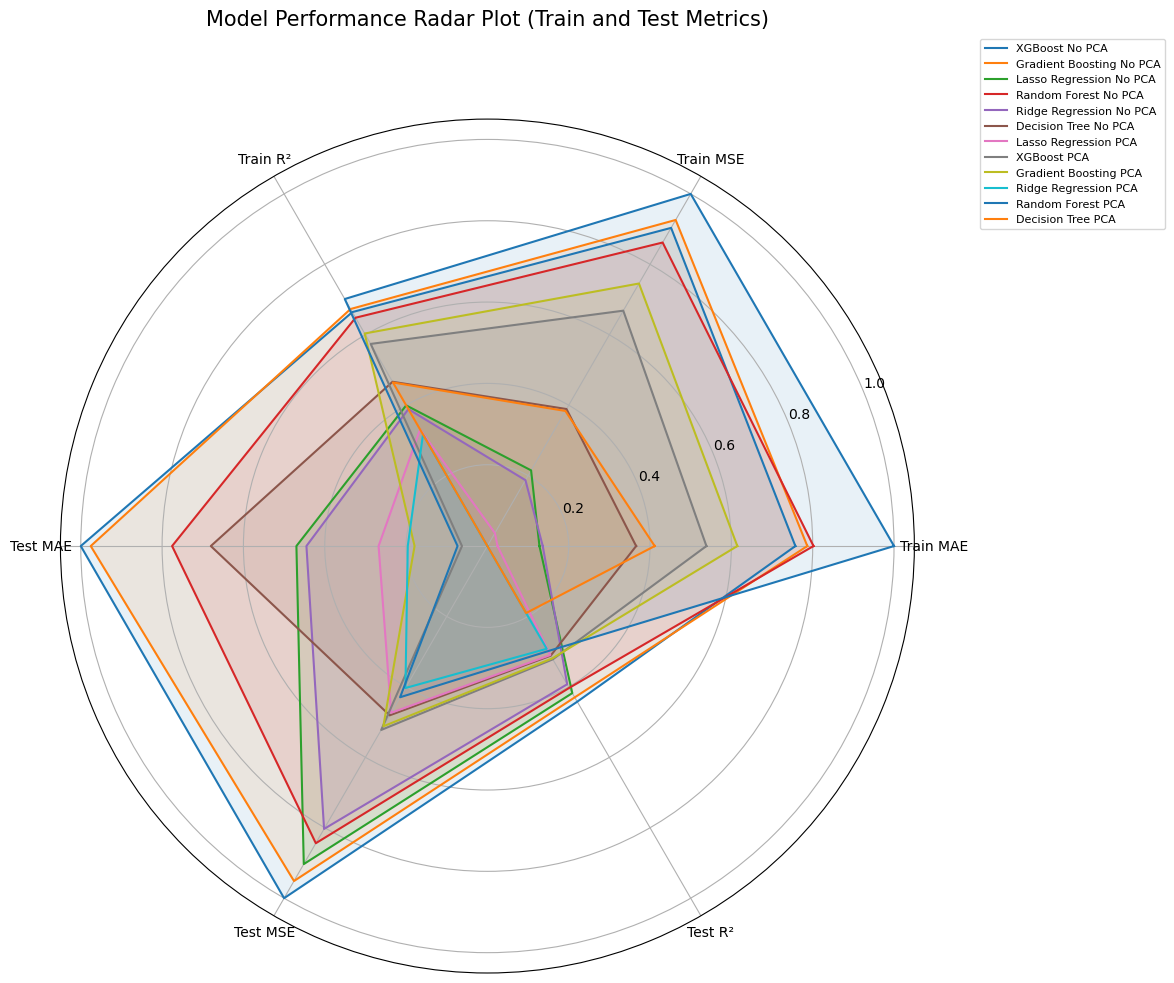

In [650]:
# 3. Radar Plot: Selected Metrics (Train and Test)


# Prepare DataFrame for normalized radar plot metrics
radar_normalized_data = pd.DataFrame(columns=['Model'] + selected_metrics)

fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))

for idx, (index, row) in enumerate(summary_table.iterrows()):
    values = row[selected_metrics].astype(float).values
    # Normalize only MAE and MSE metrics, keep R² and Composite Score as raw
    values_normalized = values.copy()
    for i, metric in enumerate(selected_metrics):
        if metric in ['Train MAE', 'Test MAE', 'Train MSE', 'Test MSE']:
            values_normalized[i] = (values[i] - heatmap_data[metric].min()) / (heatmap_data[metric].max() - heatmap_data[metric].min())
            values_normalized[i] = 1 - values_normalized[i]  # Invert error metrics
    # Store values in DataFrame
    normalized_row = [row['Model']] + values_normalized.tolist()
    radar_normalized_data.loc[idx] = normalized_row
    values_normalized = values_normalized.tolist()
    values_normalized += values_normalized[:1]
    
    ax.plot(angles, values_normalized, label=row['Model'])
    ax.fill(angles, values_normalized, alpha=0.1)

# Export normalized radar plot metrics to CSV
radar_normalized_data.to_csv('radar_normalized_metrics.csv', index=False)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(selected_metrics, fontsize=10)
ax.set_title('Model Performance Radar Plot (Train and Test Metrics)', size=15, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=8)
plt.tight_layout()

##### - Radar plot (individual)

In [651]:
# Define model order based on model_objects
model_objects_order = [
    
    'Ridge Regression',
    'Lasso Regression',
    'Decision Tree',
    'Random Forest',
    'Gradient Boosting',
    'XGBoost'
]

# Create a mapping to extract base model names from summary_table
def get_base_model(model_name):
    for base_model in model_objects_order:
        if base_model in model_name:
            return base_model
    return model_name

# Sort summary_table based on model_objects order
summary_table['Base Model'] = summary_table['Model'].apply(get_base_model)
summary_table['Model Order'] = summary_table['Base Model'].apply(lambda x: model_objects_order.index(x) if x in model_objects_order else len(model_objects_order))
summary_table = summary_table.sort_values(['Model Order', 'Model']).drop(columns=['Base Model', 'Model Order'])

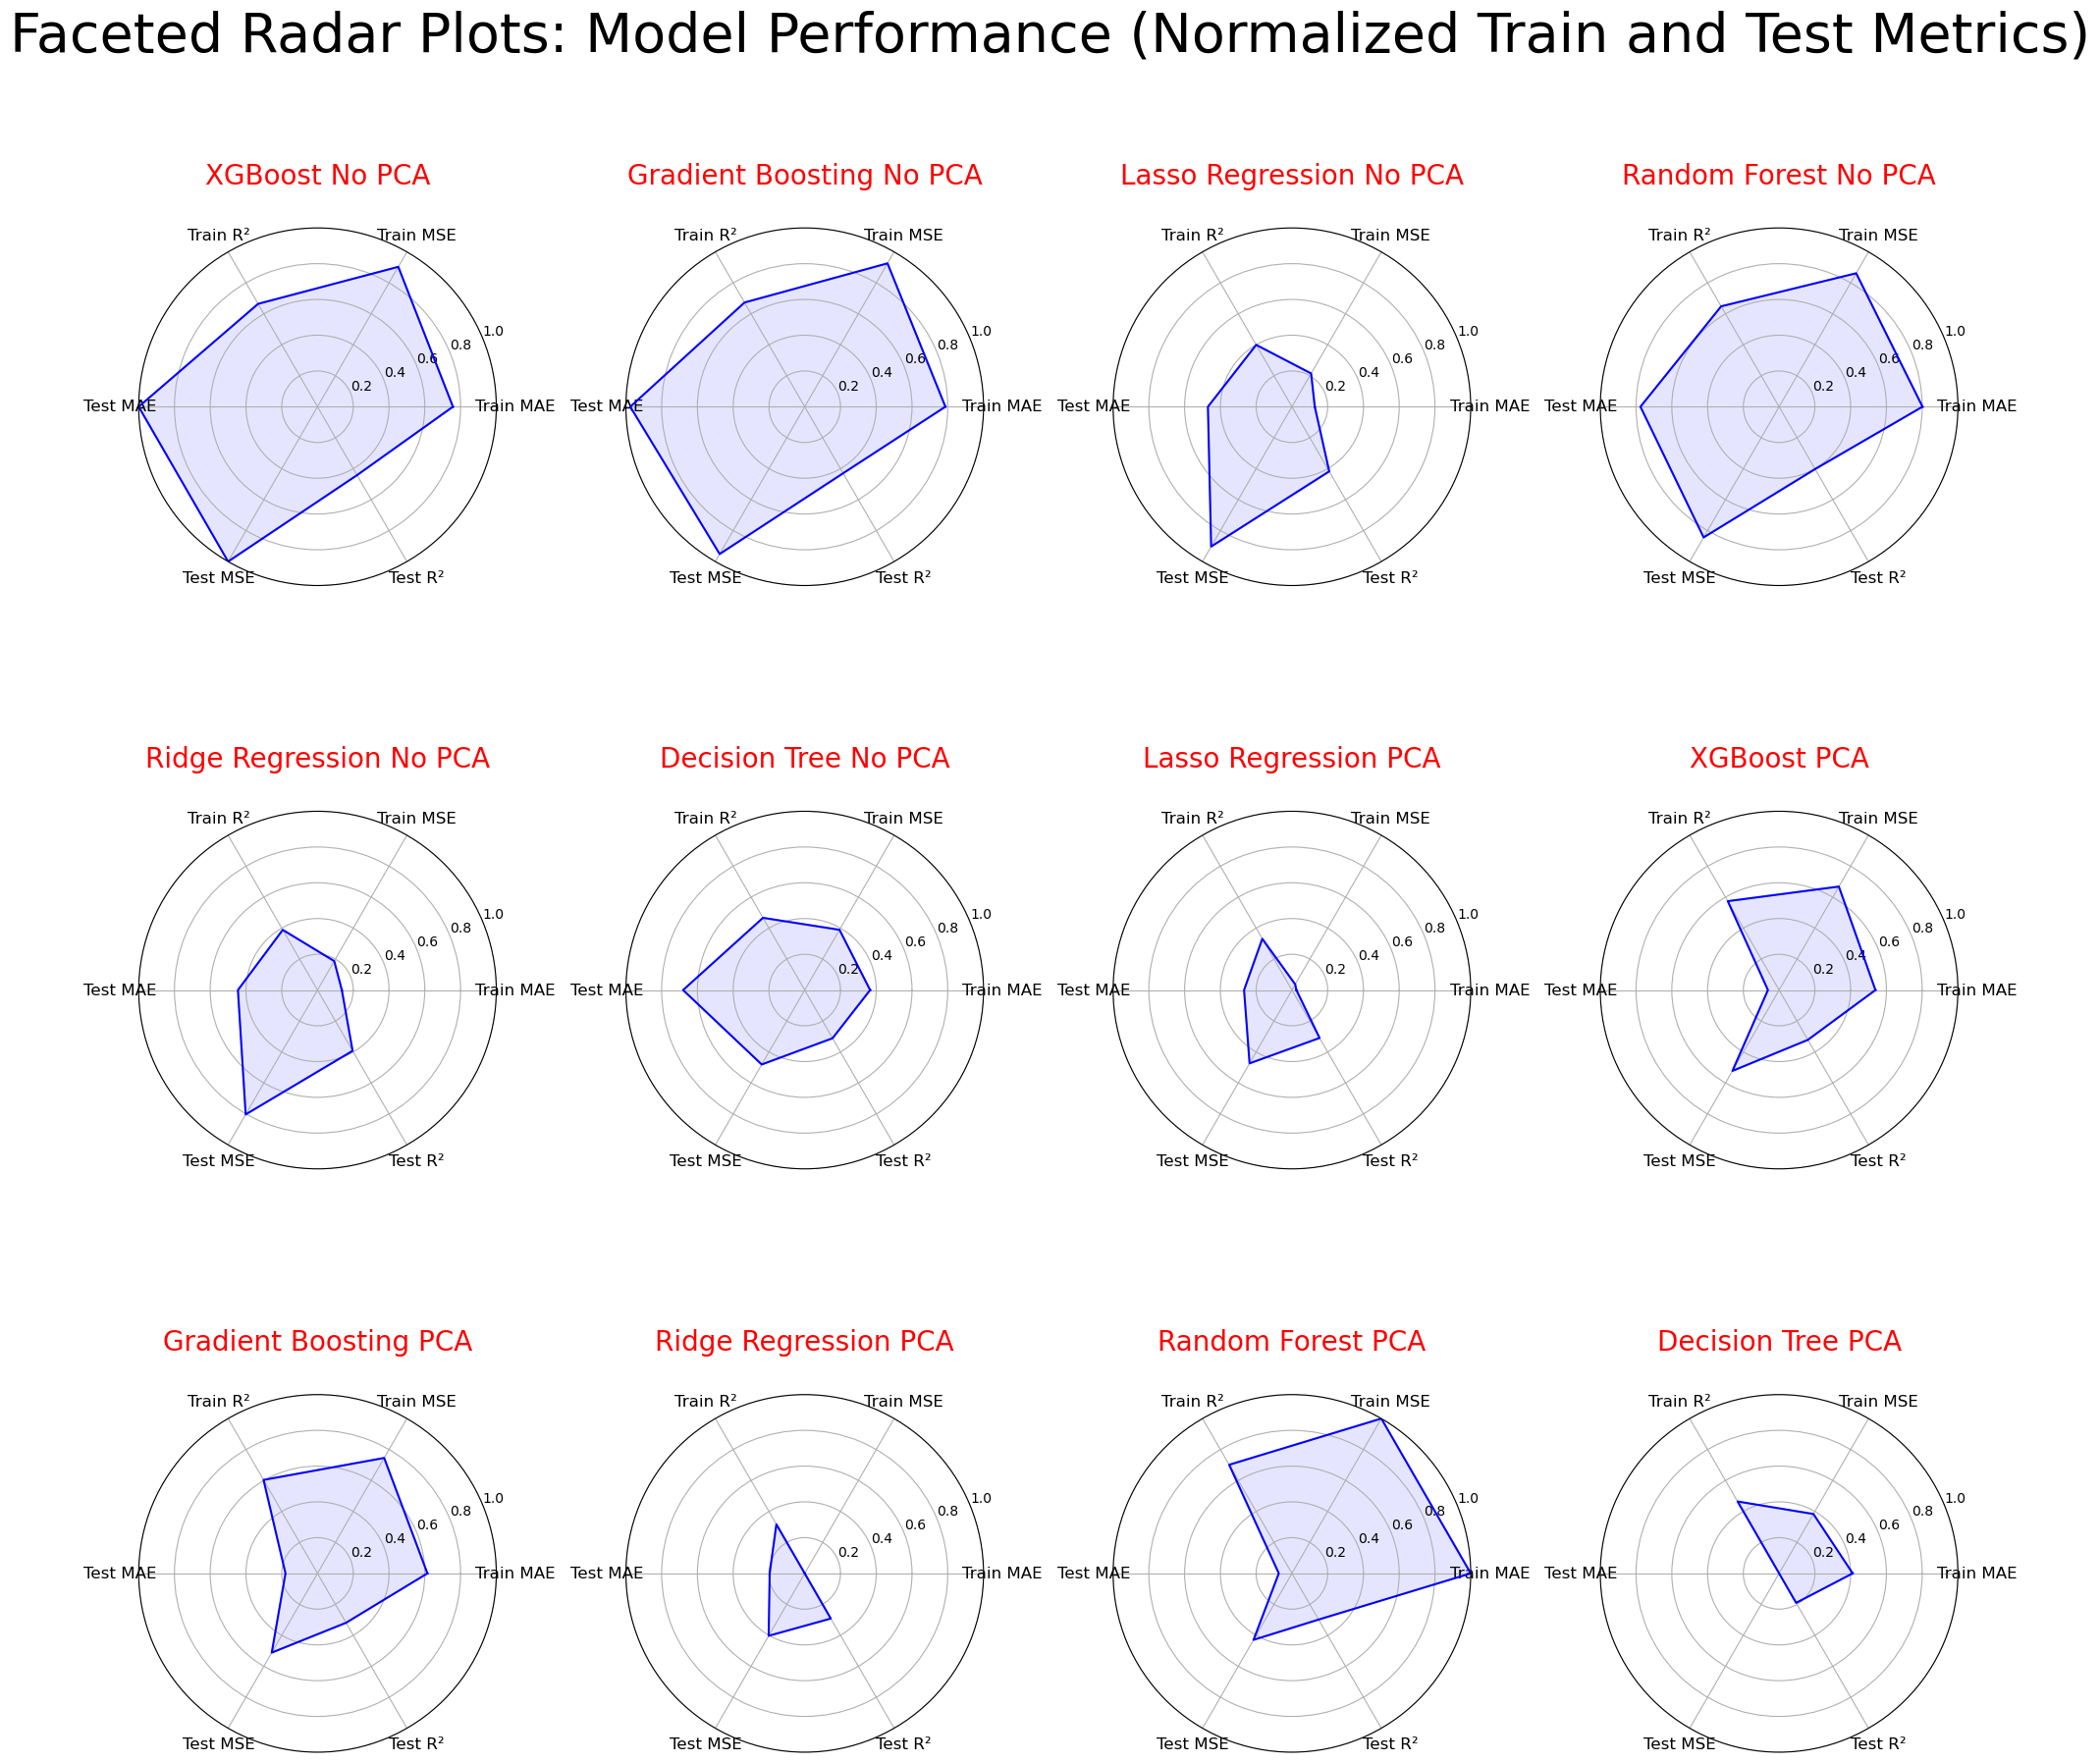

In [691]:
# 4. Faceted Radar Plot: Individual Models
fig, axes = plt.subplots(4, 4, figsize=(20, 25), subplot_kw=dict(polar=True))
axes = axes.flatten()  # Flatten to easily iterate over 14 models

for idx, (ax, (index, row)) in enumerate(zip(axes, summary_table.iterrows())):
    values = row[selected_metrics].astype(float).values
    # Normalize only MAE and MSE metrics, keep R² and Composite Score as raw
    values_normalized = values.copy()
    for i, metric in enumerate(selected_metrics):
        if metric in ['Train MAE', 'Test MAE', 'Train MSE', 'Test MSE']:
            values_normalized[i] = (values[i] - heatmap_data[metric].min()) / (heatmap_data[metric].max() - heatmap_data[metric].min())
            values_normalized[i] = 1 - values_normalized[i]  # Invert error metrics
    values_normalized = values_normalized.tolist()
    values_normalized += values_normalized[:1]
    
    ax.plot(angles, values_normalized, color='blue')
    ax.fill(angles, values_normalized, color='blue', alpha=0.1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(selected_metrics, fontsize=12)
    ax.set_title(row['Model'], size=20, y=1.1, color="red")
    ax.set_ylim(0, max(max(values_normalized), 1))  # Ensure raw R² values are visible

# Hide unused subplots (if any)
for idx in range(len(summary_table), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Faceted Radar Plots: Model Performance (Normalized Train and Test Metrics)', size=40, y=1.0)
plt.tight_layout()

The plot forms a polygon for each model. A larger, more outward polygon suggests better overall performance across metrics. In the faceted radar plot, each subplot shows one model’s polygon.

In [653]:
heatmap_data

Train MAE   Test MAE     Train MSE      Test MSE  Train R²  Test R²  \
0    82500.54  118882.18  1.429961e+10  4.810456e+10    0.6644   0.4420   
1    81295.26  119848.11  1.393104e+10  4.916261e+10    0.6731   0.4297   
2   108339.84  139812.18  2.558672e+10  5.020646e+10    0.3995   0.4176   
3    80671.26  127745.17  1.498087e+10  5.149274e+10    0.6484   0.4027   
4   108006.22  140784.79  2.604266e+10  5.237258e+10    0.3888   0.3925   
5    98578.65  131504.50  2.273185e+10  5.937483e+10    0.4665   0.3113   
6   112570.62  147787.77  2.850394e+10  5.953182e+10    0.3311   0.3095   
7    91482.46  155881.80  1.815368e+10  5.847381e+10    0.5740   0.3217   
8    88361.85  151279.72  1.688929e+10  5.869969e+10    0.6036   0.3191   
9   113595.47  150620.03  2.910938e+10  6.105770e+10    0.3169   0.2918   
10   72540.57  155452.56  1.271777e+10  6.048946e+10    0.7015   0.2984   
11   96703.05  158349.64  2.282170e+10  6.980913e+10    0.4644   0.1903   

    Composite Score  
0          0.447529  
1          0.435097  
2          0.430027  
3          0.408079  
4          0.407033  
5          0.328865  
6          0.328761  
7          0.325755  
8          0.323227  
9          0.311711  
10         0.297232  
11         0.205160

In [654]:
radar_normalized_data

Model  Train MAE  Train MSE  Train R²  Test MAE  \
0             XGBoost No PCA   0.757399   0.903497    0.6644  1.000000   
1   Gradient Boosting No PCA   0.786757   0.925982    0.6731  0.975526   
2    Lasso Regression No PCA   0.128015   0.214906    0.3995  0.469690   
3       Random Forest No PCA   0.801956   0.861935    0.6484  0.775436   
4    Ridge Regression No PCA   0.136141   0.187091    0.3888  0.445046   
5       Decision Tree No PCA   0.365774   0.389073    0.4665  0.680184   
6       Lasso Regression PCA   0.024963   0.036936    0.3311  0.267610   
7                XGBoost PCA   0.538620   0.668372    0.5740  0.062528   
8      Gradient Boosting PCA   0.614631   0.745509    0.6036  0.179133   
9       Ridge Regression PCA   0.000000   0.000000    0.3169  0.195848   
10         Random Forest PCA   1.000000   1.000000    0.7015  0.073404   
11         Decision Tree PCA   0.411459   0.383591    0.4644  0.000000   

    Test MSE  Test R²  
0   1.000000   0.4420  
1   0.951252   0.4297  
2   0.903159   0.4176  
3   0.843896   0.4027  
4   0.803359   0.3925  
5   0.480742   0.3113  
6   0.473509   0.3095  
7   0.522255   0.3217  
8   0.511848   0.3191  
9   0.403207   0.2918  
10  0.429387   0.2984  
11  0.000000   0.1903

In [655]:
print("\nModels in results list:")
for result in results:
    print(f"Model: {result['Model']}")


Models in results list:
Model: Linear Regression No PCA
Model: Linear Regression PCA
Model: Ridge Regression No PCA
Model: Ridge Regression PCA
Model: Lasso Regression No PCA
Model: Lasso Regression PCA
Model: Decision Tree No PCA
Model: Decision Tree PCA
Model: Random Forest No PCA
Model: Random Forest PCA
Model: Gradient Boosting No PCA
Model: Gradient Boosting PCA
Model: XGBoost No PCA
Model: XGBoost PCA


In [656]:
model_objects 

{'Linear Regression': LinearRegression(),
 'Ridge Regression': Ridge(max_iter=500, random_state=42),
 'Lasso Regression': Lasso(max_iter=500, random_state=42),
 'Decision Tree': DecisionTreeRegressor(random_state=42),
 'Random Forest': RandomForestRegressor(random_state=42),
 'Gradient Boosting': GradientBoostingRegressor(random_state=42),
 'XGBoost': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_

## <font color='blue'> 3. Visualization of results </font>

Mspecific_model_name to choose:

    Model: Linear Regression No PCA  
    Model: Linear Regression PCA  
    Model: Ridge Regression No PCA    
    Model: Ridge Regression PCA  
    Model: Lasso Regression No PCA  
    Model: Lasso Regression PCA  
    Model: Decision Tree No PCA  
    Model: Decision Tree PCA  
    Model: Random Forest No PCA  
    Model: Random Forest PCA  
    Model: Gradient Boosting No PCA  
    Model: Gradient Boosting PCA  
    Model: XGBoost No PCA  
    Model: XGBoost PCA  


Generating visualizations for XGBoost No PCA...

Feature Count Debugging for XGBoost No PCA:
Numerical features: 3
Product type features: 64
Product level features: 1
Temporal features: 3
Total features: 71


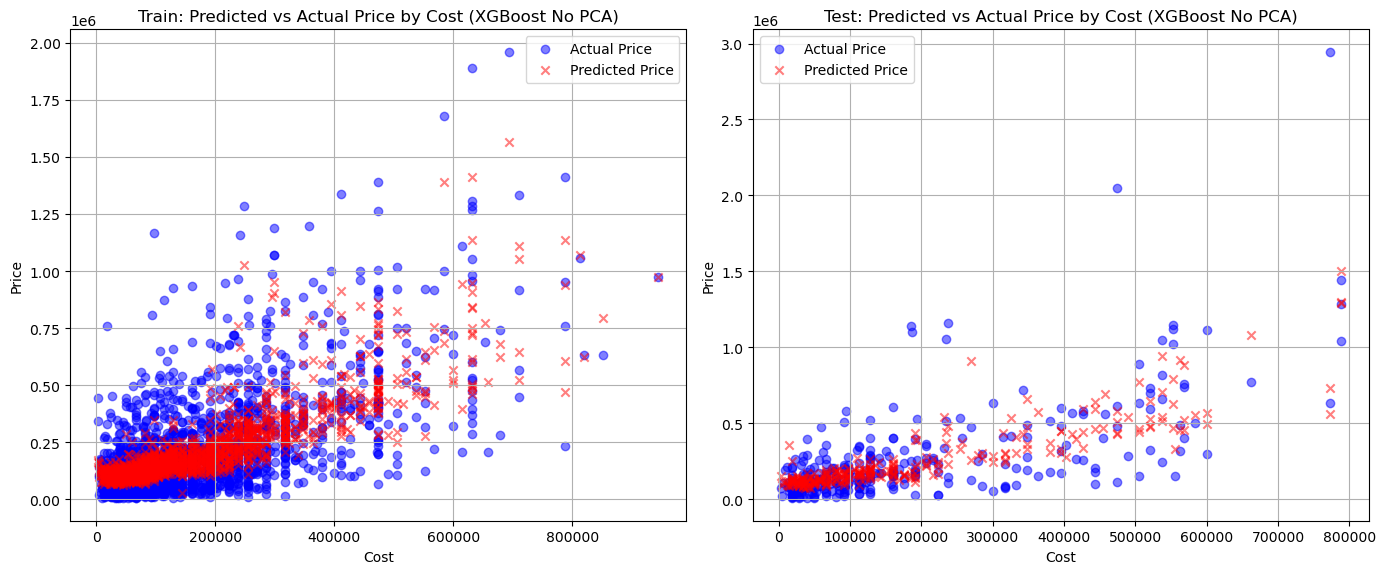

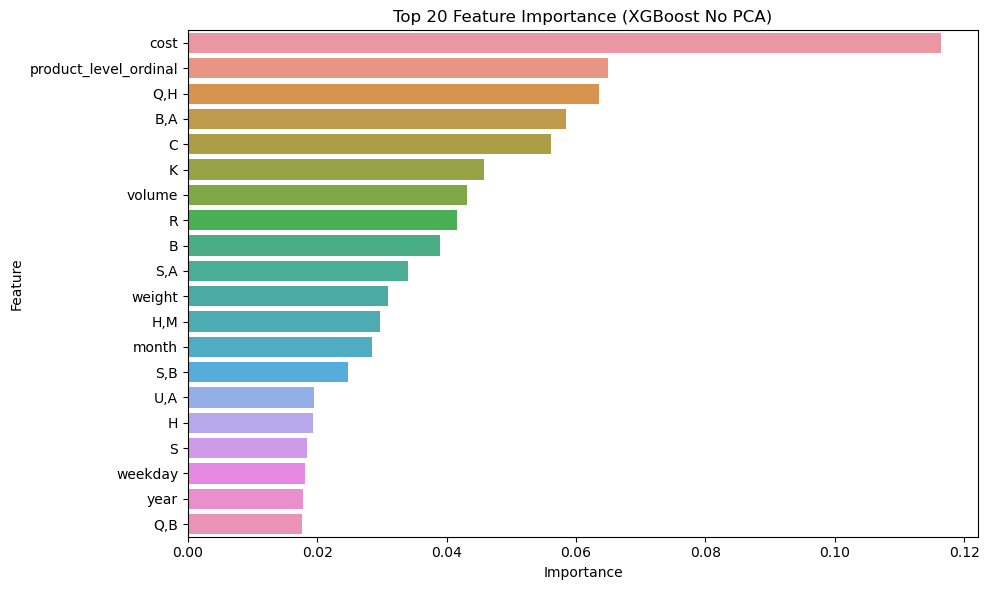

In [657]:
# Specific Model Visualization
specific_model_name = "XGBoost No PCA"  # Change this to any model name from summary_table['Model']

# Validate model name
if specific_model_name in [m[0] for m in models]:
    print(f"\nGenerating visualizations for {specific_model_name}...")
    
    # Retrieve the best estimator for the specific model
    specific_model = next(m[1].best_estimator_ for m in models if m[0] == specific_model_name)
    
    # Generate predictions
    y_train_pred = specific_model.predict(X_train)
    y_test_pred = specific_model.predict(X_test)
    cost_train = X_train['cost'].apply(cost2num)
    cost_test = X_test['cost'].apply(cost2num)
    
    # Predicted vs Actual Price Scatter Plots
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.scatter(cost_train, y_train, color='blue', label='Actual Price', alpha=0.5)
    plt.scatter(cost_train, y_train_pred, color='red', label='Predicted Price', marker='x', alpha=0.5)
    plt.xlabel('Cost')
    plt.ylabel('Price')
    plt.title(f'Train: Predicted vs Actual Price by Cost ({specific_model_name})')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.scatter(cost_test, y_test, color='blue', label='Actual Price', alpha=0.5)
    plt.scatter(cost_test, y_test_pred, color='red', label='Predicted Price', marker='x', alpha=0.5)
    plt.xlabel('Cost')
    plt.ylabel('Price')
    plt.title(f'Test: Predicted vs Actual Price by Cost ({specific_model_name})')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    # plt.savefig(f"{specific_model_name.replace(' ', '_')}_predicted_vs_actual.png")
    # plt.close()
    
    # Feature Importance (if applicable)
    if specific_model_name not in ['Linear Regression No PCA', 'Linear Regression PCA', 'Ridge Regression No PCA', 'Ridge Regression PCA', 'Lasso Regression No PCA', 'Lasso Regression PCA']:
        print(f"\nFeature Count Debugging for {specific_model_name}:")
        num_features = specific_model.named_steps['preprocessor'].named_transformers_['num'].transform(X_train[numerical_features]).shape[1]
        product_type_features = len(specific_model.named_steps['preprocessor'].named_transformers_['product_type'].keys)
        product_level_features = 1
        temp_features = len(temporal_features)
        total_features = num_features + product_type_features + product_level_features + temp_features
        print(f"Numerical features: {num_features}")
        print(f"Product type features: {product_type_features}")
        print(f"Product level features: {product_level_features}")
        print(f"Temporal features: {temp_features}")
        print(f"Total features: {total_features}")
        
        importances = specific_model.named_steps['regressor'].feature_importances_
        
        if specific_model.named_steps.get('pca') is not None:
            importance_feature_names = [f'PC{i+1}' for i in range(specific_model.named_steps['pca'].n_components)]
        else:
            try:
                importance_feature_names = []
                importance_feature_names.extend([f'num__{feat}' for feat in numerical_features])
                importance_feature_names.extend([f'product_type__{key}' for key in specific_model.named_steps['preprocessor'].named_transformers_['product_type'].keys])
                importance_feature_names.append('product_level_ordinal')
                importance_feature_names.extend([f'temp__{feat}' for feat in temporal_features])
            except AttributeError:
                print(f"Warning: Failed to construct feature names for {specific_model_name}, using fallback")
                importance_feature_names = [f'feature_{i}' for i in range(len(importances))]
        
        if len(importance_feature_names) != len(importances):
            print(f"Warning: Feature names length ({len(importance_feature_names)}) does not match importances ({len(importances)})")
            if len(importance_feature_names) > len(importances):
                importance_feature_names = importance_feature_names[:len(importances)]
            else:
                importance_feature_names = importance_feature_names + [f"unknown_{i}" for i in range(len(importances) - len(importance_feature_names))]
        
        feature_importance_df = pd.DataFrame({
            'Feature': importance_feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)
        
        feature_importance_df['Feature'] = feature_importance_df['Feature'].apply(lambda x: x.split('__')[-1])
        
        top_n = 20
        feature_importance_df = feature_importance_df.head(top_n)
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
        plt.title(f'Top {top_n} Feature Importance ({specific_model_name})')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        # plt.savefig(f"{specific_model_name.replace(' ', '_')}_feature_importance.png")
        # plt.close()
    
    # PCA Analysis (if PCA is used)
    if specific_model.named_steps.get('pca') is not None:
        pca = specific_model.named_steps['pca']
        preprocessor_fitted = specific_model.named_steps['preprocessor']
        
        try:
            feature_names = []
            feature_names.extend([f'num__{feat}' for feat in numerical_features])
            feature_names.extend([f'product_type__{key}' for key in preprocessor_fitted.named_transformers_['product_type'].keys])
            feature_names.append('product_level_ordinal')
            feature_names.extend([f'temp__{feat}' for feat in temporal_features])
        except AttributeError:
            print(f"Warning: Failed to construct PCA feature names for {specific_model_name}, using fallback")
            feature_names = [f'feature_{i}' for i in range(pca.components_.shape[1])]
        
        components = pca.components_
        n_components = pca.n_components
        
        if len(feature_names) != components.shape[1]:
            print(f"Warning: PCA feature names length ({len(feature_names)}) does not match components ({components.shape[1]})")
            if len(feature_names) > components.shape[1]:
                feature_names = feature_names[:components.shape[1]]
            else:
                feature_names = feature_names + [f"unknown_{i}" for i in range(components.shape[1] - len(feature_names))]
        
        feature_contributions = pd.DataFrame(
            np.abs(components[0]).reshape(1, -1),
            columns=feature_names,
            index=['PC1']
        )
        print(f"\nFeature Contributions to PC1 for {specific_model_name}:")
        print(feature_contributions.round(4))
        
        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance_ratio)
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        axes[0].plot(range(1, n_components + 1), explained_variance_ratio, marker='o', linestyle='-', color='b')
        axes[0].set_title('Scree Plot')
        axes[0].set_xlabel('Principal Component')
        axes[0].set_ylabel('Explained Variance Ratio')
        axes[0].grid(True)
        axes[0].set_xticks(range(1, n_components + 1))
        
        axes[1].plot(range(1, n_components + 1), cumulative_variance, marker='o', linestyle='-', color='g')
        axes[1].axhline(y=0.8, color='r', linestyle='--', alpha=0.5, label='80% Variance Threshold')
        axes[1].axhline(y=0.9, color='purple', linestyle='--', alpha=0.5, label='90% Variance Threshold')
        axes[1].set_title('Cumulative Explained Variance')
        axes[1].set_xlabel('Number of Principal Components')
        axes[1].set_ylabel('Cumulative Explained Variance Ratio')
        axes[1].grid(True)
        axes[1].legend()
        axes[1].set_xticks(range(1, n_components + 1))
        
        plt.tight_layout()
        # plt.savefig(f"{specific_model_name.replace(' ', '_')}_pca_analysis.png")
        # plt.close()
else:
    print(f"\nError: Model '{specific_model_name}' not found. Please choose a model from the following: {', '.join([m[0] for m in models])}")

## <font color='blue'> 4. Stacking Regressor </font>

In [658]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from uuid import uuid4
import ast

### 4.1 Prepare the data

In [659]:
# Fix summary_table to store Best Parameters as dictionaries
results_fixed = [
    {
        'Model': r['Model'],
        'Best Parameters': r['Best Parameters'],  # Keep as dictionary
        'Train MAE': r['Train MAE'],
        'Test MAE': r['Test MAE'],
        'Train MSE': r['Train MSE'],
        'Test MSE': r['Test MSE'],
        'Train R²': r['Train R²'],
        'Test R²': r['Test R²'],
        'Composite Score': compute_composite_score(r, max_mae, max_mse, max_r2_diff)
    }
    for r in results
]


In [660]:
# Convert string Best Parameters back to dictionaries if necessary
for r in results_fixed:
    if isinstance(r['Best Parameters'], str):
        try:
            r['Best Parameters'] = ast.literal_eval(r['Best Parameters'])
        except (ValueError, SyntaxError):
            print(f"Warning: Could not parse Best Parameters for {r['Model']}, using default parameters")
            r['Best Parameters'] = {}

In [661]:
# Recreate summary_table with Best Parameters as dictionaries
summary_table = pd.DataFrame([
    {
        'Model': r['Model'],
        'Best Parameters': r['Best Parameters'],  # Store as dictionary
        'Train MAE': f"{r['Train MAE']:.2f}",
        'Test MAE': f"{r['Test MAE']:.2f}",
        'Train MSE': f"{r['Train MSE']:.2f}",
        'Test MSE': f"{r['Test MSE']:.2f}",
        'Train R²': f"{r['Train R²']:.4f}",
        'Test R²': f"{r['Test R²']:.4f}",
        'Composite Score': compute_composite_score(r, max_mae, max_mse, max_r2_diff)
    }
    for r in results_fixed
]).sort_values(by='Composite Score', ascending=False)

In [662]:
summary_table

Model  \
12            XGBoost No PCA   
10  Gradient Boosting No PCA   
4    Lasso Regression No PCA   
8       Random Forest No PCA   
2    Ridge Regression No PCA   
1      Linear Regression PCA   
6       Decision Tree No PCA   
5       Lasso Regression PCA   
13               XGBoost PCA   
11     Gradient Boosting PCA   
3       Ridge Regression PCA   
9          Random Forest PCA   
7          Decision Tree PCA   
0   Linear Regression No PCA   

                                      Best Parameters  Train MAE   Test MAE  \
12  {'regressor__colsample_bytree': 0.6, 'regresso...   82500.54  118882.18   
10  {'regressor__learning_rate': 0.1, 'regressor__...   81295.26  119848.11   
4       {'poly__degree': 1, 'regressor__alpha': 10.0}  108339.84  139812.18   
8   {'regressor__max_depth': 20, 'regressor__max_f...   80671.26  127745.17   
2       {'poly__degree': 1, 'regressor__alpha': 10.0}  108006.22  140784.79   
1         {'pca__n_components': 9, 'poly__degree': 2}  108128.44  137160.63   
6   {'regressor__max_depth': 5, 'regressor__max_fe...   98578.65  131504.50   
5   {'pca__n_components': 9, 'poly__degree': 2, 'r...  112570.62  147787.77   
13  {'pca__n_components': 9, 'regressor__colsample...   91482.46  155881.80   
11  {'pca__n_components': 8, 'regressor__learning_...   88361.85  151279.72   
3   {'pca__n_components': 9, 'poly__degree': 2, 'r...  113595.47  150620.03   
9   {'pca__n_components': 9, 'regressor__max_depth...   72540.57  155452.56   
7   {'pca__n_components': 8, 'regressor__max_depth...   96703.05  158349.64   
0                                 {'poly__degree': 2}   91187.65  148882.21   

         Train MSE        Test MSE Train R² Test R²  Composite Score  
12  14299606780.05  48104562054.58   0.6644  0.4420         0.447529  
10  13931041081.00  49162606995.94   0.6731  0.4297         0.435097  
4   25586717774.87  50206463573.20   0.3995  0.4176         0.430027  
8   14980872971.70  51492740251.76   0.6484  0.4027         0.408079  
2   26042663873.01  52372577634.95   0.3888  0.3925         0.407033  
1   26122410902.20  52683398392.59   0.3870  0.3889         0.404922  
6   22731852841.43  59374826756.38   0.4665  0.3113         0.328865  
5   28503935259.87  59531822477.65   0.3311  0.3095         0.328761  
13  18153679428.65  58473807545.77   0.5740  0.3217         0.325755  
11  16889285826.41  58699689062.08   0.6036  0.3191         0.323227  
3   29109381182.65  61057696167.24   0.3169  0.2918         0.311711  
9   12717767826.65  60489463360.71   0.7015  0.2984         0.297232  
7   22821703058.28  69809129027.10   0.4644  0.1903         0.205160  
0   17507595588.37  83770622021.40   0.5891  0.0283         0.047594

### 4.2 Define base learners for StackingRegressor

In [663]:
# Define base learners for StackingRegressor
base_learners = []
for model_name in model_objects_order:
    # Get No PCA and PCA results from summary_table
    no_pca_result = summary_table[summary_table['Model'] == f"{model_name} No PCA"]
    pca_result = summary_table[summary_table['Model'] == f"{model_name} PCA"]
    
    for result, use_pca in [(no_pca_result, False), (pca_result, True)]:
        if not result.empty:
            best_params = result['Best Parameters'].iloc[0]
            model_key = model_name
            
            # Initialize the base model
            model = model_objects[model_key]
            
            # Get valid parameters for the base estimator
            valid_params = model.get_params().keys()
            
            # Clean and filter parameters
            cleaned_params = {}
            poly_degree = None
            if isinstance(best_params, dict):
                for param, value in best_params.items():
                    # Handle pipeline-specific parameters
                    if param.startswith('poly__'):
                        if param == 'poly__degree':
                            poly_degree = value
                    elif param.startswith('regressor__'):
                        cleaned_param = param.replace('regressor__', '')
                        if cleaned_param in valid_params:
                            cleaned_params[cleaned_param] = value
                        else:
                            print(f"Warning: Parameter {cleaned_param} not valid for {model_key}, skipping")
                    elif param in valid_params:  # Direct parameters (e.g., from non-pipeline grid search)
                        cleaned_params[param] = value
                    else:
                        print(f"Warning: Parameter {param} not valid for {model_key}, skipping")
            else:
                print(f"Warning: Best Parameters for {model_key} is not a dictionary, using default parameters")
            
            # Set the best parameters for the base estimator
            try:
                model.set_params(**cleaned_params)
            except Exception as e:
                print(f"Warning: Failed to set parameters for {model_key}: {e}")
            
            # Create pipeline
            if use_pca:
                pipeline = Pipeline([
                    ('preprocessor', preprocessor),
                    ('pca', PCA(n_components=min(n_features, 10))),  # Adjust n_components as needed
                    ('regressor', model)
                ])
                learner_name = f"{model_name} PCA"
            else:
                if model_name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression']:
                    # Use the degree from best_params if available
                    degree = poly_degree if poly_degree is not None else 2  # Default to 2 if not specified
                    pipeline = Pipeline([
                        ('preprocessor', preprocessor),
                        ('poly', PolynomialFeatures(degree=degree)),
                        ('regressor', model)
                    ])
                else:
                    pipeline = Pipeline([
                        ('preprocessor', preprocessor),
                        ('regressor', model)
                    ])
                learner_name = f"{model_name} No PCA"
            
            base_learners.append((learner_name, pipeline))

#### 4.3 Define the StackingRegressor

In [664]:
# Define the StackingRegressor with Ridge as meta-regressor
# meta_regressor = Ridge(random_state=42)

meta_regressor = XGBRegressor(random_state=42, n_estimators=100, max_depth=5, learning_rate=0.1, verbosity=0)
stacking_regressor = StackingRegressor(
    estimators=base_learners,
    final_estimator=meta_regressor,
    cv=5,  # 5-fold cross-validation
    n_jobs=-1  # Use all available cores
)


#### 4.4 Fit the model

In [665]:
# Fit the StackingRegressor
print("\nFitting StackingRegressor with 5-fold cross-validation...")
try:
    stacking_regressor.fit(X_train, y_train)
except Exception as e:
    print(f"Error fitting StackingRegressor: {e}")
    raise


Fitting StackingRegressor with 5-fold cross-validation...


#### 4.5 Evaluate the results

In [666]:
# Evaluate the StackingRegressor
y_train_pred = stacking_regressor.predict(X_train)
y_test_pred = stacking_regressor.predict(X_test)

stacking_metrics = {
    'Train MAE': mean_absolute_error(y_train, y_train_pred),
    'Test MAE': mean_absolute_error(y_test, y_test_pred),
    'Train MSE': mean_squared_error(y_train, y_train_pred),
    'Test MSE': mean_squared_error(y_test, y_test_pred),
    'Train R²': r2_score(y_train, y_train_pred),
    'Test R²': r2_score(y_test, y_test_pred)
}

In [667]:
# Replace negative metrics with zero
for key in stacking_metrics:
    if stacking_metrics[key] < 0:
        stacking_metrics[key] = 0.0
        
# Compute composite score
stacking_score = compute_composite_score(stacking_metrics, max_mae, max_mse, max_r2_diff)

# Create result dictionary for StackingRegressor
stacking_result = {
    'Model': 'Stacking Regressor',
    'Best Parameters': {},  # No grid search for stacking
    'Train MAE': stacking_metrics['Train MAE'],
    'Test MAE': stacking_metrics['Test MAE'],
    'Train MSE': stacking_metrics['Train MSE'],
    'Test MSE': stacking_metrics['Test MSE'],
    'Train R²': stacking_metrics['Train R²'],
    'Test R²': stacking_metrics['Test R²'],
    'Composite Score': stacking_score
}

# Append to results and create new summary table
results_fixed.append(stacking_result)
new_summary_table = pd.DataFrame([
    {
        'Model': r['Model'],
        'Best Parameters': r['Best Parameters'],  # Store as dictionary
        'Train MAE': f"{r['Train MAE']:.2f}",
        'Test MAE': f"{r['Test MAE']:.2f}",
        'Train MSE': f"{r['Train MSE']:.2f}",
        'Test MSE': f"{r['Test MSE']:.2f}",
        'Train R²': f"{r['Train R²']:.4f}",
        'Test R²': f"{r['Test R²']:.4f}",
        'Composite Score': r['Composite Score']
    }
    for r in results_fixed
]).sort_values(by='Composite Score', ascending=False)

# Export new summary table to Excel
new_summary_table.to_excel('new_summary_table.xlsx', index=False, engine='openpyxl')

print("\nNew Summary Table with Stacking Regressor:")
print(new_summary_table.to_string(index=False))


New Summary Table with Stacking Regressor:
                   Model                                                                                                                                                                                                        Best Parameters Train MAE  Test MAE      Train MSE       Test MSE Train R² Test R²  Composite Score
          XGBoost No PCA                         {'regressor__colsample_bytree': 0.6, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__min_child_weight': 3, 'regressor__n_estimators': 50, 'regressor__subsample': 1.0}  82500.54 118882.18 14299606780.05 48104562054.58   0.6644  0.4420         0.447529
Gradient Boosting No PCA                                                       {'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__min_samples_leaf': 5, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 50}  81295.26 119848.11 13931041081.00 49162606995.94   0.6731  0.4297  

#### 4.6 Visualizations of results

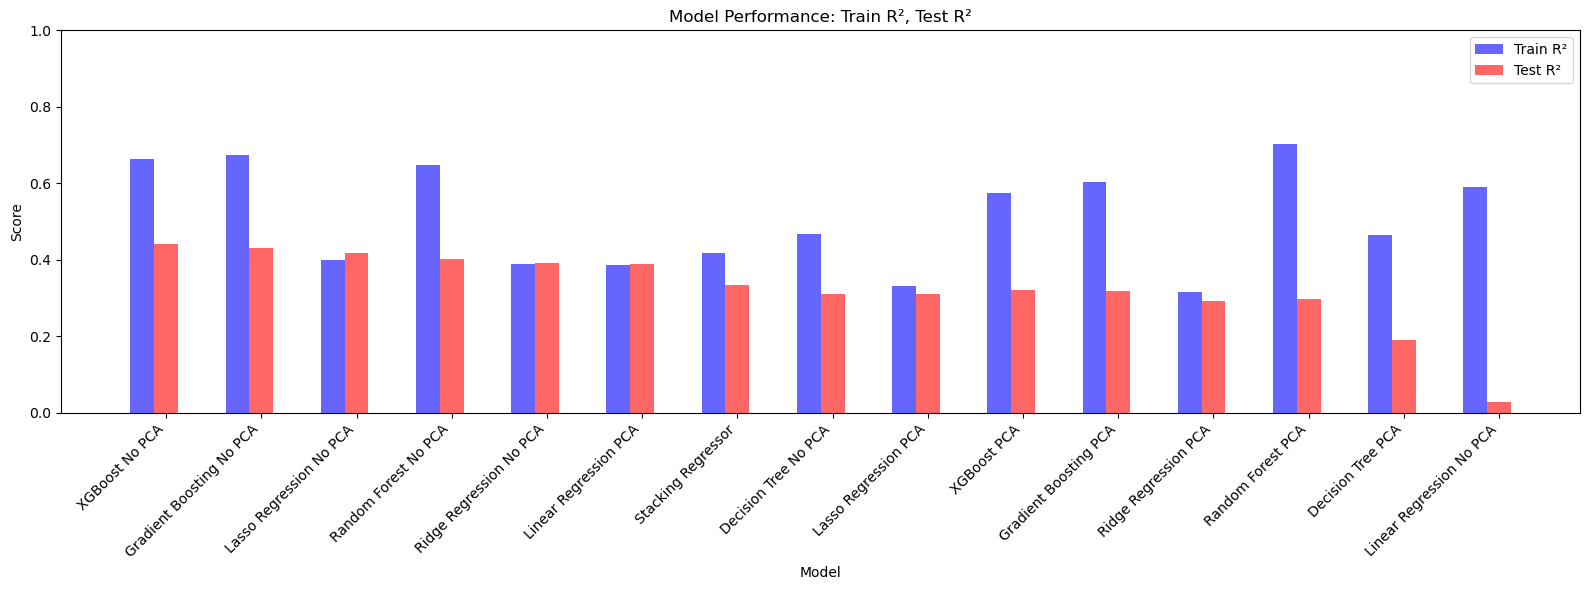

In [668]:
# --- Visualizations ---

# 1. Bar Plot: Train R², Test R²
plt.figure(figsize=(16, 6))
bar_width = 0.25
index = np.arange(len(new_summary_table))

plt.bar(index, new_summary_table['Train R²'].astype(float), bar_width, label='Train R²', color='blue', alpha=0.6)
plt.bar(index + bar_width, new_summary_table['Test R²'].astype(float), bar_width, label='Test R²', color='red', alpha=0.6)
plt.ylim([0, 1])
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance: Train R², Test R²')
plt.xticks(index + bar_width, new_summary_table['Model'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()


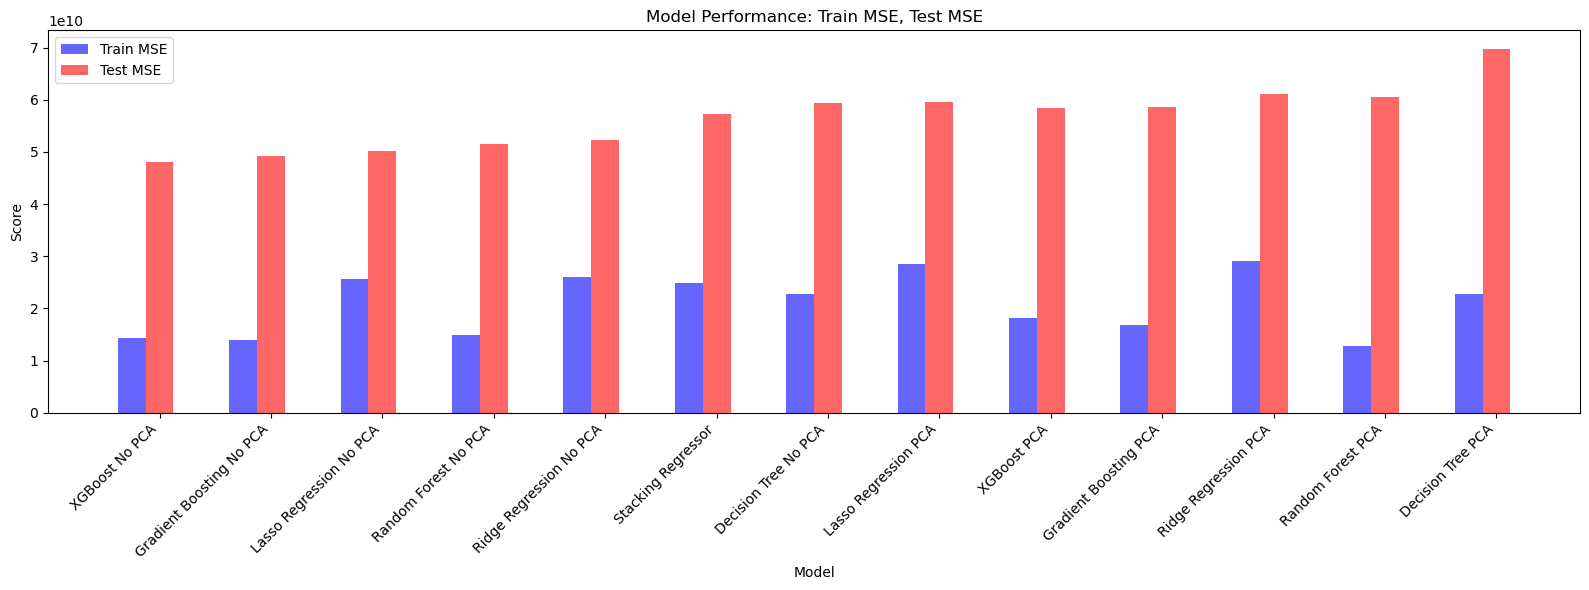

In [669]:
# 2. Bar Plot: Train MSE, Test MSE (excluding Linear Regression)
filtered_summary = new_summary_table[~new_summary_table['Model'].str.contains('Linear Regression')].reset_index(drop=True)
plt.figure(figsize=(16, 6))
index = np.arange(len(filtered_summary))

plt.bar(index, filtered_summary['Train MSE'].astype(float), bar_width, label='Train MSE', color='blue', alpha=0.6)
plt.bar(index + bar_width, filtered_summary['Test MSE'].astype(float), bar_width, label='Test MSE', color='red', alpha=0.6)
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance: Train MSE, Test MSE')
plt.xticks(index + bar_width, filtered_summary['Model'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()

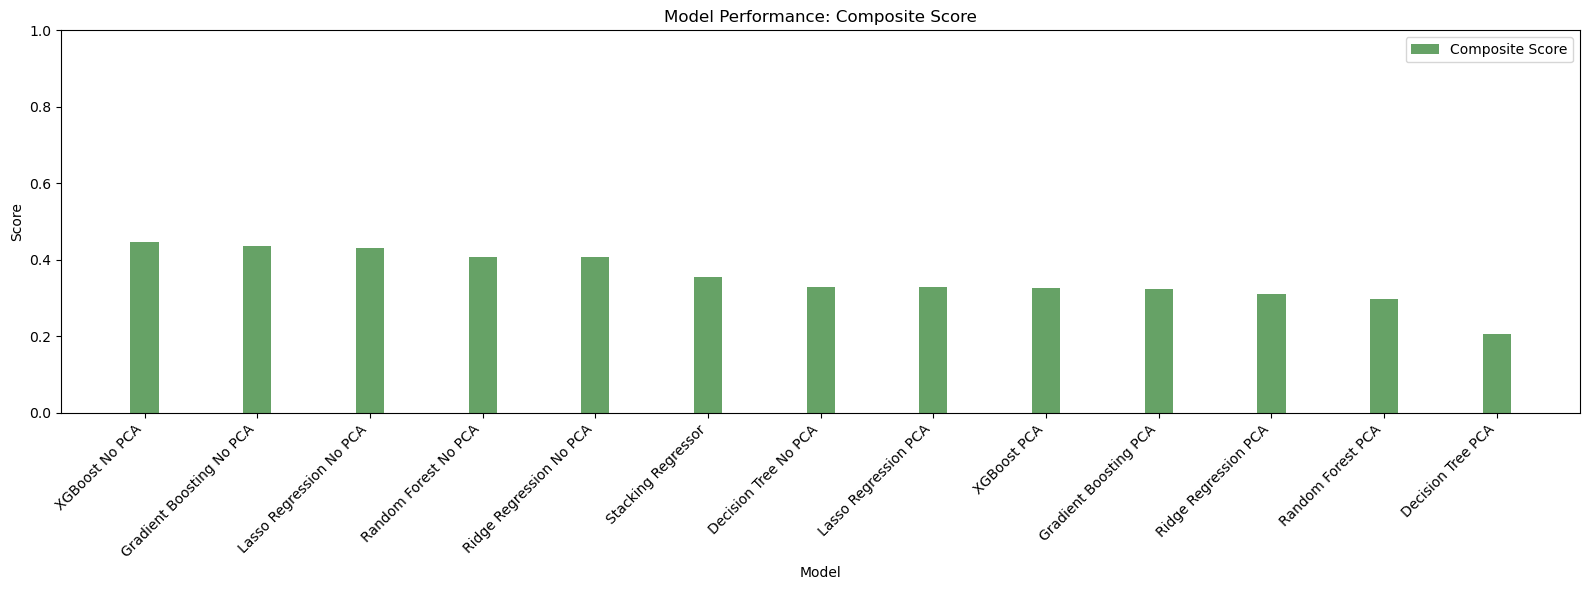

In [670]:
# 3. Bar Plot: Composite Score
plt.figure(figsize=(16, 6))
index = np.arange(len(filtered_summary))

plt.bar(index, filtered_summary['Composite Score'].astype(float), bar_width, label='Composite Score', color='darkgreen', alpha=0.6)
plt.ylim([0, 1])
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance: Composite Score')
plt.xticks(index, filtered_summary['Model'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()

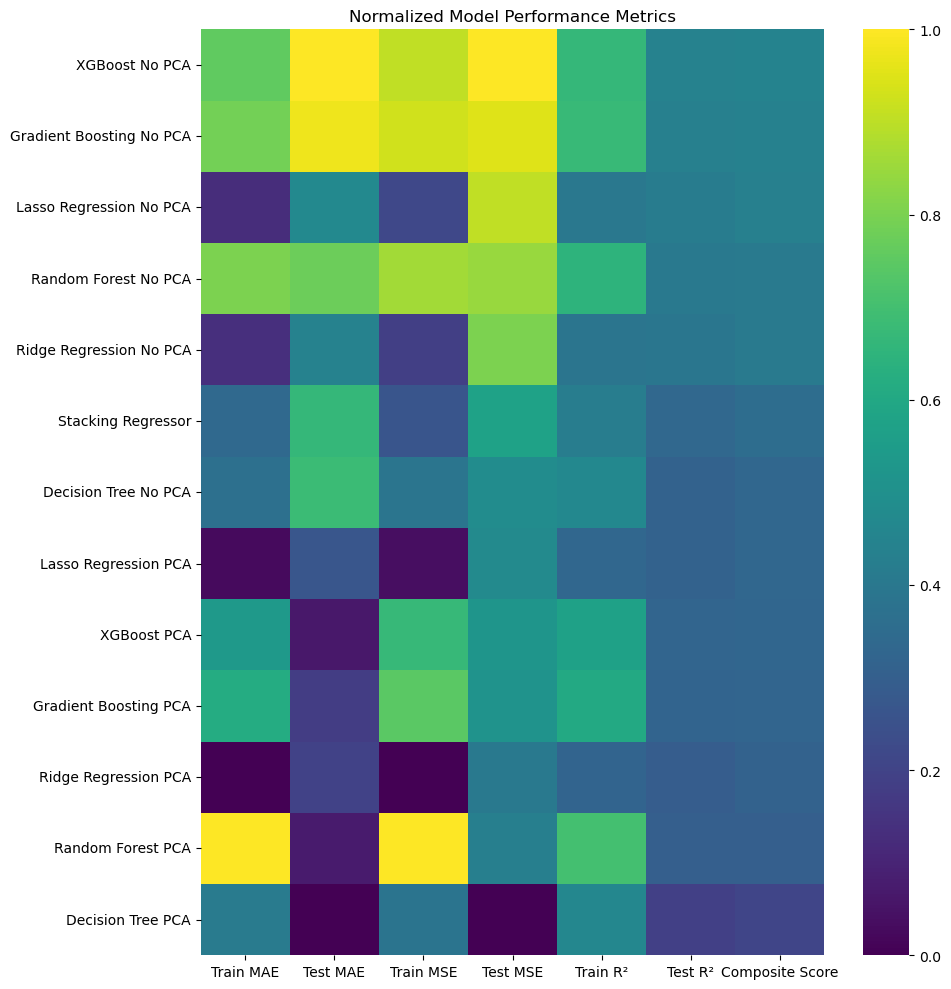

In [671]:
# 4. Heatmap: Normalized Metrics
metrics_columns = ['Train MAE', 'Test MAE', 'Train MSE', 'Test MSE', 'Train R²', 'Test R²', 'Composite Score']
heatmap_data = filtered_summary[metrics_columns].astype(float)

heatmap_data_normalized = heatmap_data.copy()
for col in ['Train MAE', 'Test MAE', 'Train MSE', 'Test MSE']:
    heatmap_data_normalized[col] = (heatmap_data[col] - heatmap_data[col].min()) / (heatmap_data[col].max() - heatmap_data[col].min())
    heatmap_data_normalized[col] = 1 - heatmap_data_normalized[col]  # Invert error metrics

heatmap_data_normalized['Model'] = filtered_summary['Model']
heatmap_data_normalized = heatmap_data_normalized[['Model'] + metrics_columns]
heatmap_data_normalized.to_csv('new_normalized_metrics.csv', index=False)

plt.figure(figsize=(10, 10))
sns.heatmap(heatmap_data_normalized[metrics_columns], cmap='viridis', fmt='.2f', xticklabels=metrics_columns, yticklabels=filtered_summary['Model'])
plt.title('Normalized Model Performance Metrics')
plt.tight_layout()

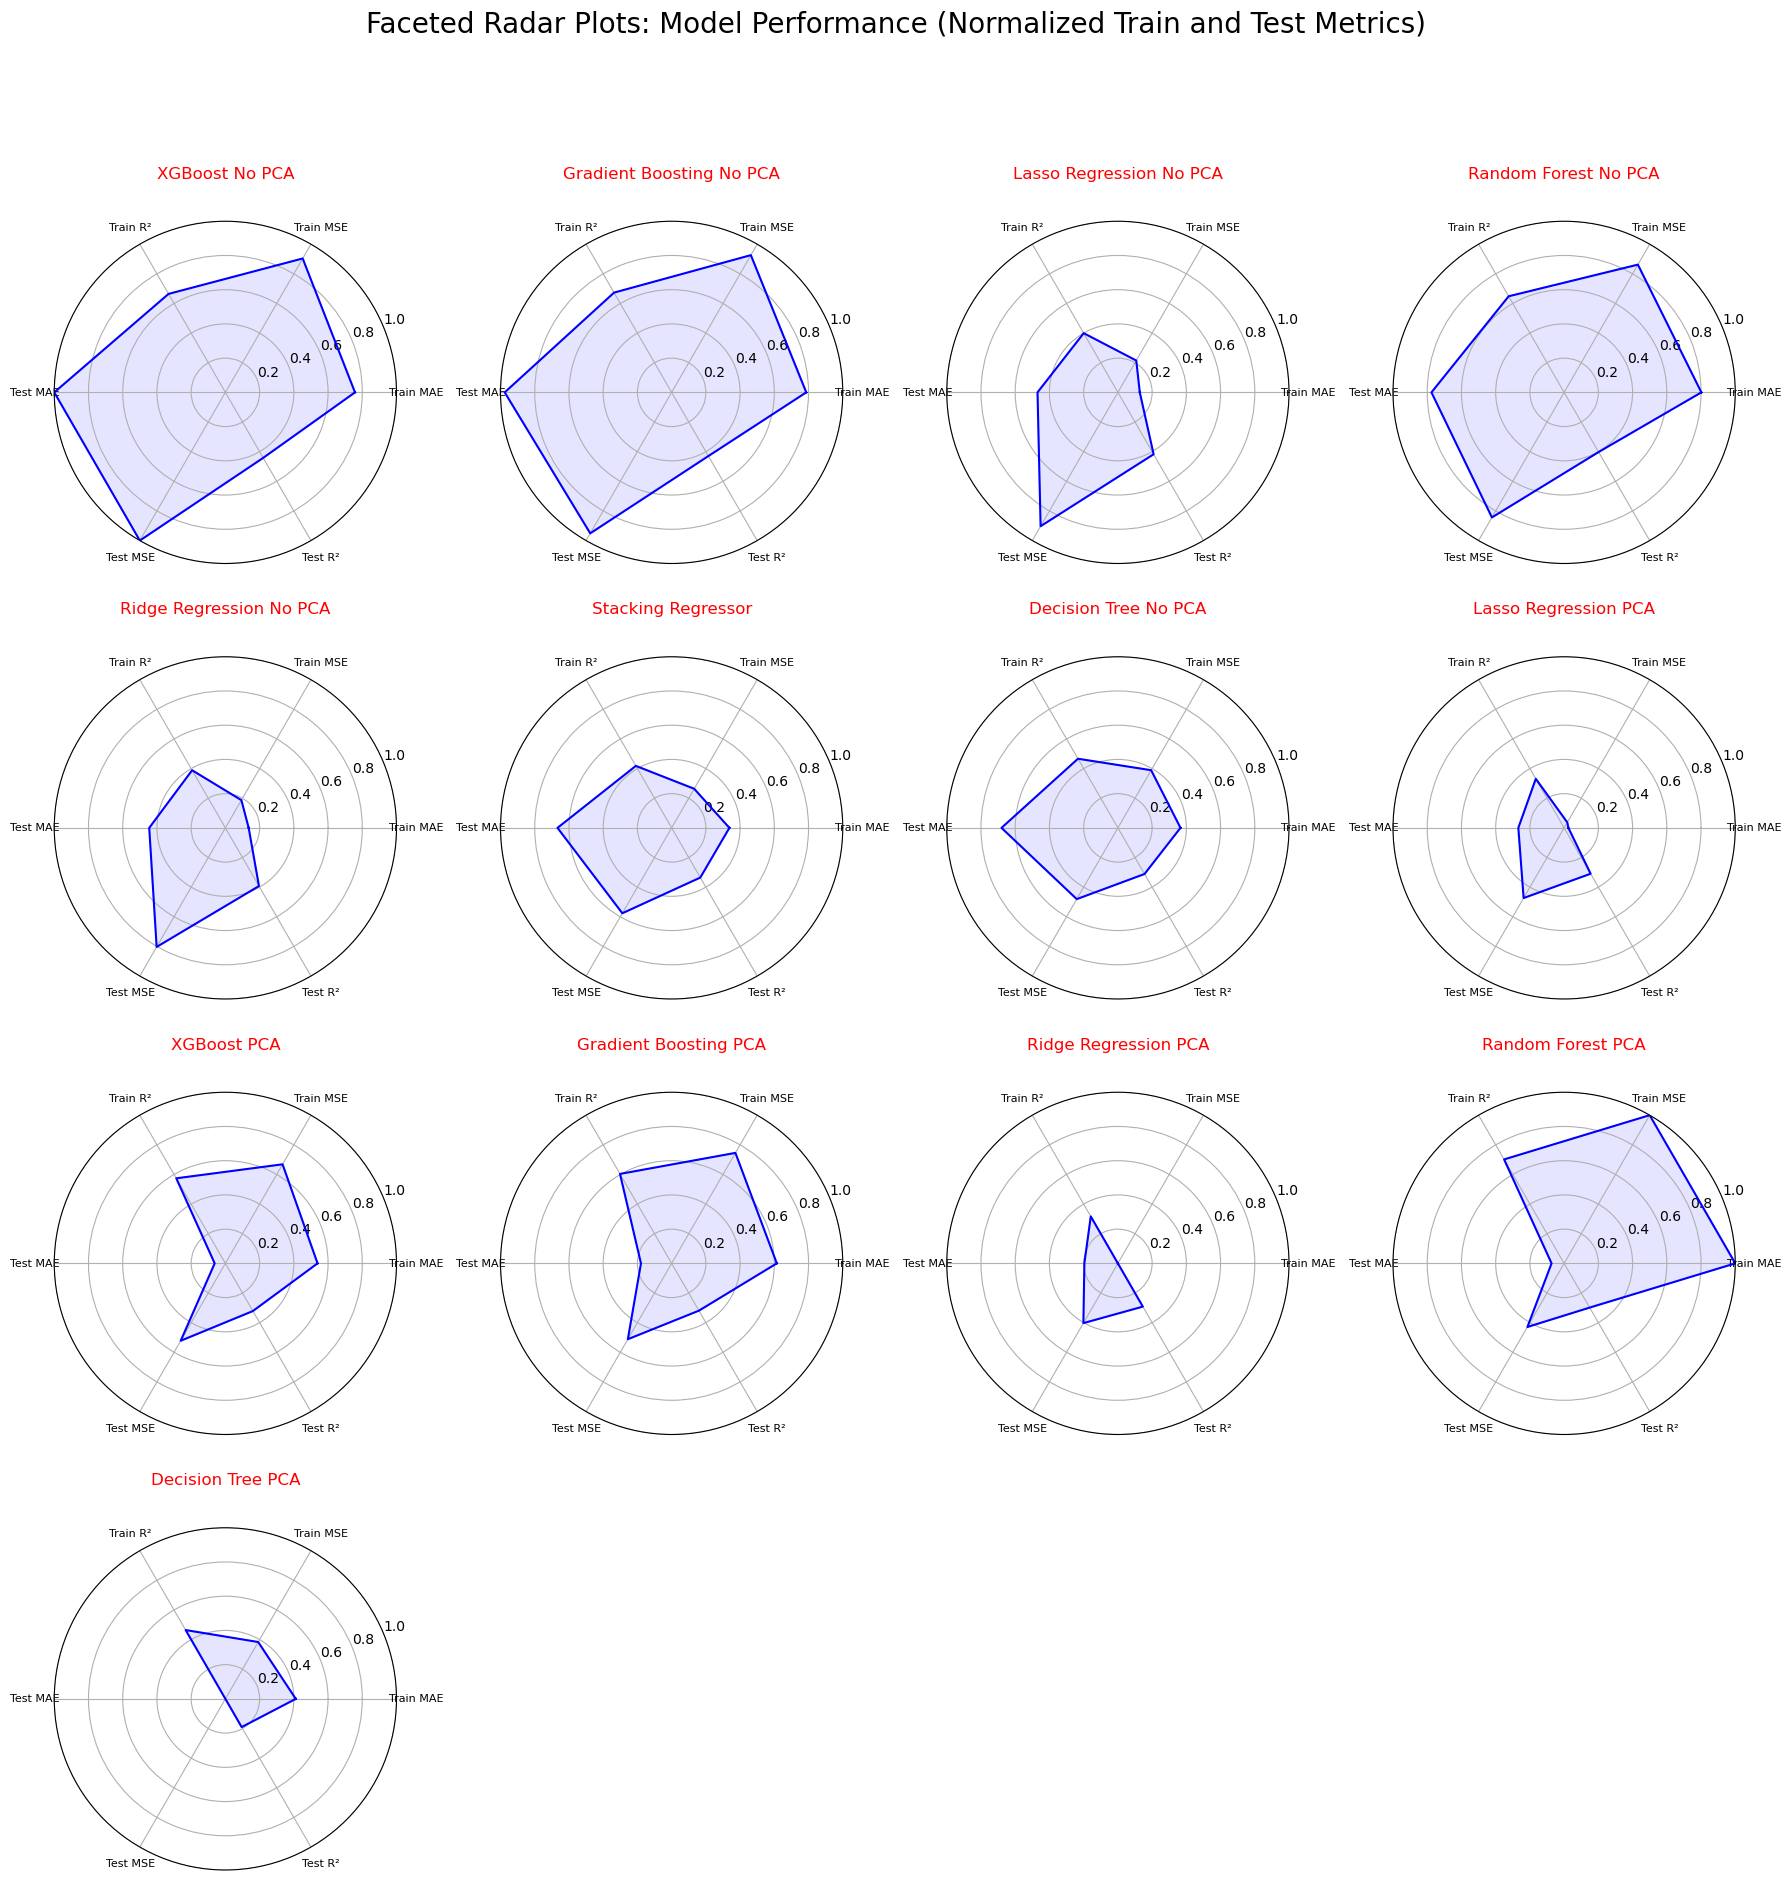

In [672]:
# 5. Faceted Radar Plot
fig, axes = plt.subplots(4, 4, figsize=(18, 18), subplot_kw=dict(polar=True))
axes = axes.flatten()

for idx, (ax, (index, row)) in enumerate(zip(axes, filtered_summary.iterrows())):
    values = row[selected_metrics].astype(float).values
    values_normalized = values.copy()
    for i, metric in enumerate(selected_metrics):
        if metric in ['Train MAE', 'Test MAE', 'Train MSE', 'Test MSE']:
            values_normalized[i] = (values[i] - heatmap_data[metric].min()) / (heatmap_data[metric].max() - heatmap_data[metric].min())
            values_normalized[i] = 1 - values_normalized[i]
    values_normalized = values_normalized.tolist()
    values_normalized += values_normalized[:1]
    
    ax.plot(angles, values_normalized, color='blue')
    ax.fill(angles, values_normalized, color='blue', alpha=0.1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(selected_metrics, fontsize=8)
    ax.set_title(row['Model'], size=12, y=1.1, color="red")
    ax.set_ylim(0, max(max(values_normalized), 1))

for idx in range(len(filtered_summary), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Faceted Radar Plots: Model Performance (Normalized Train and Test Metrics)', size=20, y=1.05)
plt.tight_layout()


Generating visualizations for Stacking Regressor...


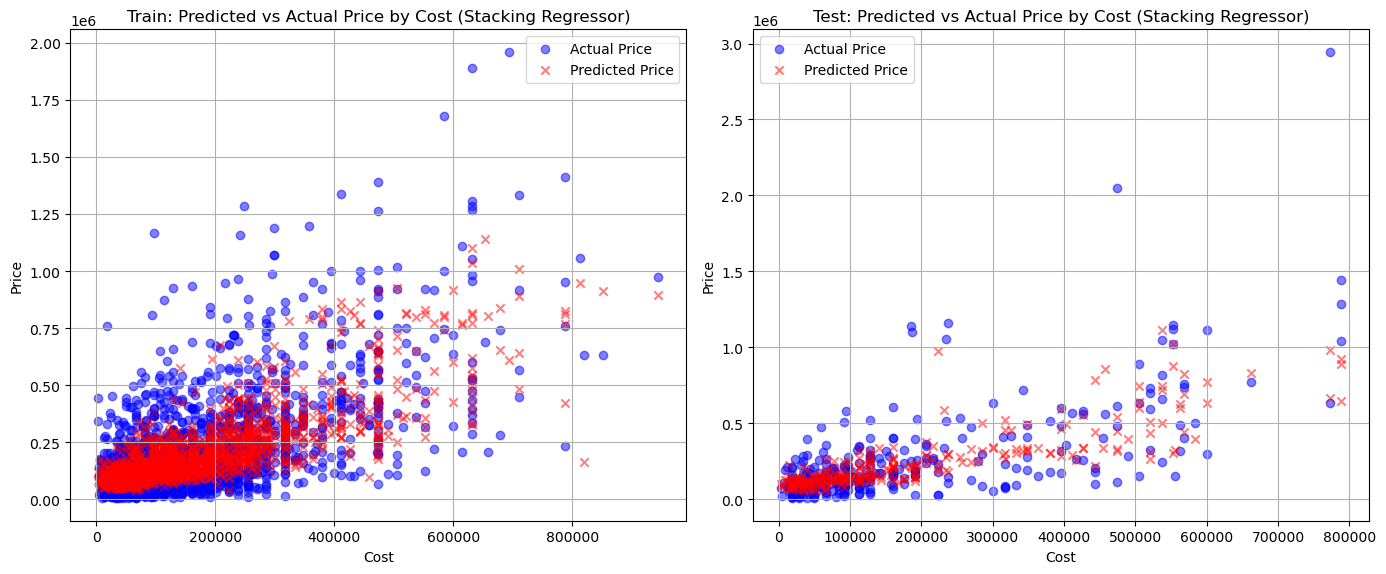

In [673]:
# 6. Specific Model Visualization: Stacking Regressor
print("\nGenerating visualizations for Stacking Regressor...")

# Predicted vs Actual Price Scatter Plots
cost_train = X_train['cost'].apply(cost2num)
cost_test = X_test['cost'].apply(cost2num)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(cost_train, y_train, color='blue', label='Actual Price', alpha=0.5)
plt.scatter(cost_train, y_train_pred, color='red', label='Predicted Price', marker='x', alpha=0.5)
plt.xlabel('Cost')
plt.ylabel('Price')
plt.title('Train: Predicted vs Actual Price by Cost (Stacking Regressor)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(cost_test, y_test, color='blue', label='Actual Price', alpha=0.5)
plt.scatter(cost_test, y_test_pred, color='red', label='Predicted Price', marker='x', alpha=0.5)
plt.xlabel('Cost')
plt.ylabel('Price')
plt.title('Test: Predicted vs Actual Price by Cost (Stacking Regressor)')
plt.legend()
plt.grid(True)

plt.tight_layout()
